In [2]:
import sys
sys.path.append('../src')  # Add current directory if needed

from ml_accident_severity_pipeline import (
    MLPipeline, 
    Config, 
    DataPreparator,
    ModelFactory,
    ModelTrainer,
    ModelEvaluator,
    Visualizer,
    SHAPExplainer
)

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("✅ Pipeline module imported successfully!")

✅ Pipeline module imported successfully!


In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_parquet('../data/processed/us_accidents_polars.parquet')
df

Severity           Start_Time State  Temperature(F)  Humidity(%)  \
0               3  2016-02-08 05:46:00    OH            36.9         91.0   
1               2  2016-02-08 06:07:59    OH            37.9        100.0   
2               2  2016-02-08 06:49:27    OH            36.0        100.0   
3               3  2016-02-08 07:23:34    OH            35.1         96.0   
4               2  2016-02-08 07:39:07    OH            36.0         89.0   
...           ...                  ...   ...             ...          ...   
7705754         2  2019-08-23 18:03:25    CA            86.0         40.0   
7705755         2  2019-08-23 19:11:30    CA            70.0         73.0   
7705756         2  2019-08-23 19:00:21    CA            73.0         64.0   
7705757         2  2019-08-23 19:00:21    CA            71.0         81.0   
7705758         2  2019-08-23 18:52:06    CA            79.0         47.0   

         Pressure(in)  Visibility(mi) Wind_Direction  Wind_Speed(mph)  \
0               29.68            10.0           Calm              8.0   
1               29.65            10.0           Calm              8.1   
2               29.67            10.0             SW              3.5   
3               29.64             9.0             SW              4.6   
4               29.65             6.0             SW              3.5   
...               ...             ...            ...              ...   
7705754         28.92            10.0              W             13.0   
7705755         29.39            10.0             SW              6.0   
7705756         29.74            10.0            SSW             10.0   
7705757         29.62            10.0             SW              8.0   
7705758         28.63             7.0             SW              7.0   

         Precipitation(in) Weather_Condition  Amenity   Bump  Crossing  \
0                     0.02        Light Rain    False  False     False   
1                     0.00        Light Rain    False  False     False   
2                     0.00          Overcast    False  False     False   
3                     0.00     Mostly Cloudy    False  False     False   
4                     0.00     Mostly Cloudy    False  False     False   
...                    ...               ...      ...    ...       ...   
7705754               0.00              Fair    False  False     False   
7705755               0.00              Fair    False  False     False   
7705756               0.00     Partly Cloudy    False  False     False   
7705757               0.00              Fair    False  False     False   
7705758               0.00              Fair    False  False     False   

         Give_Way  Junction  No_Exit  Railway  Roundabout  Station   Stop  \
0           False     False    False    False       False    False  False   
1           False     False    False    False       False    False  False   
2           False     False    False    False       False    False  False   
3           False     False    False    False       False    False  False   
4           False     False    False    False       False    False  False   
...           ...       ...      ...      ...         ...      ...    ...   
7705754     False     False    False    False       False    False  False   
7705755     False     False    False    False       False    False  False   
7705756     False      True    False    False       False    False  False   
7705757     False     False    False    False       False    False  False   
7705758     False     False    False    False       False    False  False   

         Traffic_Calming  Traffic_Signal  Turning_Loop Sunrise_Sunset  \
0                  False           False         False          Night   
1                  False           False         False          Night   
2                  False            True         False          Night   
3                  False           False         False          Night   
4                  False    

In [6]:
print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['Severity'].value_counts(normalize=True).round(4) * 100)

Dataset shape: (7705759, 29)

Target distribution:
Severity
2    79.66
3    16.82
4     2.64
1     0.87
Name: proportion, dtype: float64


In [7]:
if 'Start_Time' in df.columns:
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='mixed')
    df['start_month'] = df['Start_Time'].dt.month
    df['start_year'] = df['Start_Time'].dt.year
    df['start_hour'] = df['Start_Time'].dt.hour
    df['start_day'] = df['Start_Time'].dt.dayofweek

In [8]:
df.drop(columns=['Start_Time'], inplace=True, axis=1, errors='ignore')

In [9]:
for col in df.select_dtypes(include=['object']).columns:
    print(f"Column: {col}, Unique Values: {df[col].nunique()}")

Column: State, Unique Values: 49
Column: Wind_Direction, Unique Values: 24
Column: Weather_Condition, Unique Values: 144
Column: Sunrise_Sunset, Unique Values: 2
Column: Civil_Twilight, Unique Values: 2
Column: Nautical_Twilight, Unique Values: 2
Column: Astronomical_Twilight, Unique Values: 2


In [10]:
df['Wind_Direction'].unique()

array(['Calm', 'SW', 'SSW', 'WSW', 'WNW', 'NW', 'West', 'NNW', 'NNE',
       'South', 'North', 'Variable', 'SE', 'SSE', 'ESE', 'East', 'NE',
       'ENE', 'E', 'W', None, 'S', 'VAR', 'CALM', 'N'], dtype=object)

In [11]:
df['Weather_Condition'].unique()

array(['Light Rain', 'Overcast', 'Mostly Cloudy', 'Rain', 'Light Snow',
       'Haze', 'Scattered Clouds', 'Partly Cloudy', 'Clear', 'Snow',
       'Light Freezing Drizzle', 'Light Drizzle', 'Fog', 'Shallow Fog',
       'Heavy Rain', 'Light Freezing Rain', 'Cloudy', 'Drizzle', None,
       'Light Rain Showers', 'Mist', 'Smoke', 'Patches of Fog',
       'Light Freezing Fog', 'Light Haze', 'Light Thunderstorms and Rain',
       'Thunderstorms and Rain', 'Fair', 'Volcanic Ash', 'Blowing Sand',
       'Blowing Dust / Windy', 'Widespread Dust', 'Fair / Windy',
       'Rain Showers', 'Mostly Cloudy / Windy', 'Light Rain / Windy',
       'Hail', 'Heavy Drizzle', 'Showers in the Vicinity', 'Thunderstorm',
       'Light Rain Shower', 'Light Rain with Thunder',
       'Partly Cloudy / Windy', 'Thunder in the Vicinity', 'T-Storm',
       'Heavy Thunderstorms and Rain', 'Thunder', 'Heavy T-Storm',
       'Funnel Cloud', 'Heavy T-Storm / Windy', 'Blowing Snow',
       'Light Thunderstorms and Snow'

In [12]:
dict(df['Weather_Condition'].value_counts())

{'Fair': np.int64(2560802),
 'Mostly Cloudy': np.int64(1016195),
 'Cloudy': np.int64(817082),
 'Clear': np.int64(808743),
 'Partly Cloudy': np.int64(698972),
 'Overcast': np.int64(382866),
 'Light Rain': np.int64(352957),
 'Scattered Clouds': np.int64(204829),
 'Light Snow': np.int64(128680),
 'Fog': np.int64(99238),
 'Rain': np.int64(84331),
 'Haze': np.int64(76223),
 'Fair / Windy': np.int64(35671),
 'Heavy Rain': np.int64(32309),
 'Light Drizzle': np.int64(22684),
 'Thunder in the Vicinity': np.int64(17611),
 'Cloudy / Windy': np.int64(17035),
 'T-Storm': np.int64(16810),
 'Mostly Cloudy / Windy': np.int64(16508),
 'Snow': np.int64(15537),
 'Thunder': np.int64(14202),
 'Light Rain with Thunder': np.int64(13597),
 'Smoke': np.int64(12668),
 'Wintry Mix': np.int64(11703),
 'Partly Cloudy / Windy': np.int64(10241),
 'Heavy T-Storm': np.int64(9671),
 'Light Rain / Windy': np.int64(7946),
 'Light Snow / Windy': np.int64(6826),
 'Heavy Snow': np.int64(5003),
 'Light Thunderstorms and Rain

In [13]:
def group_weather_conditions(condition):
    """
    Groups weather conditions into broader categories.
    """
    condition = str(condition).lower()
    if 't-storm' in condition or 'thunder' in condition:
        return 'Thunderstorm'
    elif 'snow' in condition or 'sleet' in condition or 'ice' in condition or 'wintry' in condition or 'freezing' in condition or 'hail' in condition:
        return 'Snow/Ice'
    elif 'rain' in condition or 'drizzle' in condition or 'shower' in condition:
        return 'Rain'
    elif 'cloudy' in condition or 'overcast' in condition:
        return 'Cloudy'
    elif 'scattered clouds' in condition or 'partly cloudy' in condition or 'mostly cloudy' in condition:
        return 'Partly Cloudy'
    elif 'fog' in condition or 'mist' in condition or 'haze' in condition:
        return 'Fog/Mist/Haze'
    elif 'clear' in condition or 'fair' in condition:
        return 'Clear/Fair'
    elif 'smoke' in condition or 'dust' in condition or 'sand' in condition or 'ash' in condition:
        return 'Smoke/Dust/Sand'
    elif 'squalls' in condition or 'tornado' in condition or 'funnel' in condition:
        return 'Severe'
    else:
        return 'Other'

In [14]:
df['Weather_Group'] = df['Weather_Condition'].apply(group_weather_conditions)

In [15]:
df['Weather_Group'].value_counts()

Weather_Group
Clear/Fair         3405216
Cloudy             2958899
Rain                512097
Partly Cloudy       204829
Fog/Mist/Haze       188634
Snow/Ice            179749
Other               154076
Thunderstorm         88603
Smoke/Dust/Sand      13533
Severe                 123
Name: count, dtype: int64

In [16]:
df[df['Weather_Group'] == 'Other']['Weather_Condition'].value_counts()

Weather_Condition
N/A Precipitation    3252
Name: count, dtype: int64

In [17]:
df.drop(columns=(['Weather_Condition']), inplace=True, axis=1, errors='ignore')

In [18]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7705759 entries, 0 to 7705758
Data columns (total 32 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   Severity                 int64   
 1   State                    category
 2   Temperature(F)           float64 
 3   Humidity(%)              float64 
 4   Pressure(in)             float64 
 5   Visibility(mi)           float64 
 6   Wind_Direction           category
 7   Wind_Speed(mph)          float64 
 8   Precipitation(in)        float64 
 9   Amenity                  bool    
 10  Bump                     bool    
 11  Crossing                 bool    
 12  Give_Way                 bool    
 13  Junction                 bool    
 14  No_Exit                  bool    
 15  Railway                  bool    
 16  Roundabout               bool    
 17  Station                  bool    
 18  Stop                     bool    
 19  Traffic_Calming          bool    
 20  Traffic_Signal          

In [20]:
df[['start_month', 'start_year', 'start_hour', 'start_day']] = df[['start_month', 'start_year', 'start_hour', 'start_day']].astype('category')

In [21]:
for col in df.select_dtypes(include=['category']).columns:
    print(f"Column: {col}, Categories: {df[col].cat.categories}, Num Categories: {len(df[col].cat.categories)}")

Column: State, Categories: Index(['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'IA', 'ID',
       'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS',
       'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR',
       'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV',
       'WY'],
      dtype='object'), Num Categories: 49
Column: Wind_Direction, Categories: Index(['CALM', 'Calm', 'E', 'ENE', 'ESE', 'East', 'N', 'NE', 'NNE', 'NNW',
       'NW', 'North', 'S', 'SE', 'SSE', 'SSW', 'SW', 'South', 'VAR',
       'Variable', 'W', 'WNW', 'WSW', 'West'],
      dtype='object'), Num Categories: 24
Column: Sunrise_Sunset, Categories: Index(['Day', 'Night'], dtype='object'), Num Categories: 2
Column: Civil_Twilight, Categories: Index(['Day', 'Night'], dtype='object'), Num Categories: 2
Column: Nautical_Twilight, Categories: Index(['Day', 'Night'], dtype='object'), Num Categories: 2
Column: Astronomical_Twilight, Categories: I

In [22]:
df[df.isna().any(axis=1)]

Severity State  Temperature(F)  Humidity(%)  Pressure(in)  \
601             3    OH            44.6         69.0         29.36   
1957            2    CA            57.0         77.0         29.95   
1968            2    CA            57.0         77.0         29.95   
1973            2    CA            57.0         77.0         29.95   
1978            2    CA            57.0         77.0         29.95   
...           ...   ...             ...          ...           ...   
7705628         2    OR            70.0         61.0         26.07   
7705639         2    OR            70.0         60.0         29.92   
7705697         2    CA            76.0         56.0         29.72   
7705717         4    CA            90.0         17.0         24.91   
7705718         4    CA            90.0         17.0         24.91   

         Visibility(mi) Wind_Direction  Wind_Speed(mph)  Precipitation(in)  \
601                10.0            NaN             10.4                0.0   
1957               10.0            NaN              6.0                0.0   
1968               10.0            NaN              6.0                0.0   
1973               10.0            NaN              6.0                0.0   
1978               10.0            NaN              6.0                0.0   
...                 ...            ...              ...                ...   
7705628            10.0           CALM              0.0                0.0   
7705639            10.0            WNW              5.0                0.0   
7705697            10.0            NaN              7.0                0.0   
7705717            10.0            VAR              7.0                0.0   
7705718            10.0            VAR              7.0                0.0   

         Amenity   Bump  Crossing  Give_Way  Junction  No_Exit  Railway  \
601        False  False     False     False     False    False    False   
1957       False  False      True     False     False    False    False   
1968       False  False     False     False     False    False    False   
1973       False  False     False     False     False    False    False   
1978       False  False     False     False     False    False    False   
...          ...    ...       ...       ...       ...      ...      ...   
7705628    False  False     False     False     False    False    False   
7705639    False  False     False     False     False    False    False   
7705697    False  False     False     False      True    False    False   
7705717    False  False     False     False     False    False    False   
7705718    False  False     False     False     False    False    False   

         Roundabout  Station   Stop  Traffic_Calming  Traffic_Signal  \
601           False    False  False            False           False   
1957          False    False  False            False            True   
1968          False    False  False            False           False   
1973          False    False  False            False           False   
1978          False    False  False            False           False   
...             ...      ...    ...              ...             ...   
7705628       False    False  False            False           False   
7705639       False    False  False            False           False   
7705697       False    False  False            False           False   
7705717       False    False  False            False           False   
7705718       False    False  False            False           False   

         Turning_Loop Sunrise_Sunset Civil_Twilight Nautical_Twilight  \
601             False            Day            Day               Day   
1957            False          Night          Night             Night   
1968            False            Day            Day               Day   
1973            False            Day            Day               Day   
1978            False            Day            Day               Day   
...               ...      

## Machine Learning

In [23]:
# Create configuration
config = Config()

# Customize parameters as needed
config.TEST_SIZE = 0.2
config.CV_FOLDS = 2
config.N_ITER_SEARCH = 3       # Increase for better results (e.g., 100)
config.RANDOM_STATE = 42
config.SCORING_METRIC = 'balanced_accuracy'
config.SHAP_SAMPLE_SIZE = 1000  # Reduce for faster SHAP computation
config.TOP_FEATURES_SHAP = 20

# Define time-based categorical columns (passthrough, no encoding)
config.TIME_CAT_COLS = ['start_month', 'start_year', 'start_hour', 'start_day']

print("✅ Configuration set!")
print(f"   - CV Folds: {config.CV_FOLDS}")
print(f"   - Search Iterations: {config.N_ITER_SEARCH}")
print(f"   - Scoring Metric: {config.SCORING_METRIC}")

✅ Configuration set!
   - CV Folds: 2
   - Search Iterations: 3
   - Scoring Metric: balanced_accuracy


STARTING COMPLETE ML PIPELINE

📊 STEP 1: Data Preparation
Column Types Identified:
  Numerical: 7
  Categorical (to encode): 7
  Time categorical (passthrough): 4
  Boolean: 13

Class Distribution:
  Class 1: 53,758 (0.87%)
  Class 2: 4,910,990 (79.66%)
  Class 3: 1,036,946 (16.82%)
  Class 4: 162,913 (2.64%)

🏭 STEP 2: Creating Model Configurations

🎯 STEP 3: Training Models with RandomizedSearchCV
STARTING RANDOMIZED SEARCH CV FOR ALL MODELS
CV Folds: 2
N Iterations: 3
Scoring Metric: balanced_accuracy

Training: XGBoost
Fitting 2 folds for each of 3 candidates, totalling 6 fits

XGBoost Best CV Score: 0.6905
Best Parameters:
  colsample_bytree: 0.749816
  gamma: 0.475357
  learning_rate: 0.120571
  max_depth: 7
  min_child_weight: 7
  n_estimators: 221
  reg_alpha: 0.004207
  reg_lambda: 0.001707
  subsample: 0.946470

Training: LightGBM
Fitting 2 folds for each of 3 candidates, totalling 6 fits

LightGBM Best CV Score: 0.6986
Best Parameters:
  colsample_bytree: 0.749816
  learning

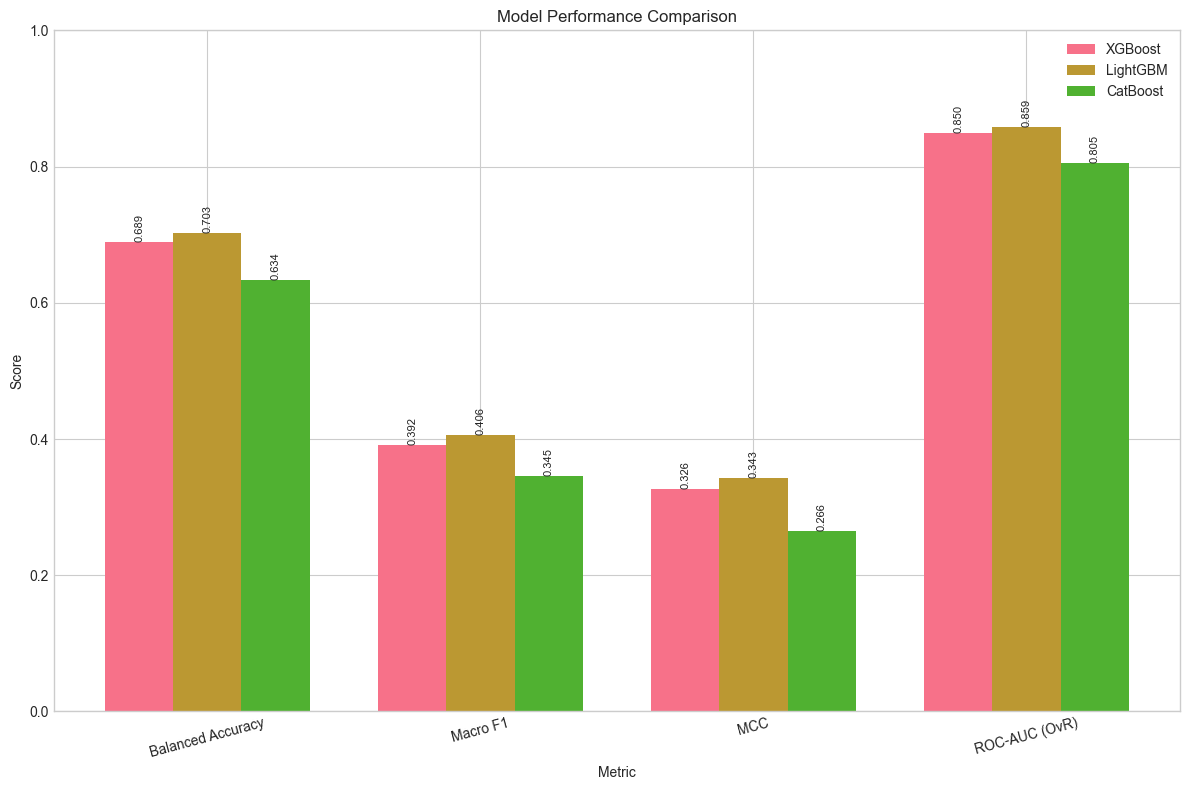

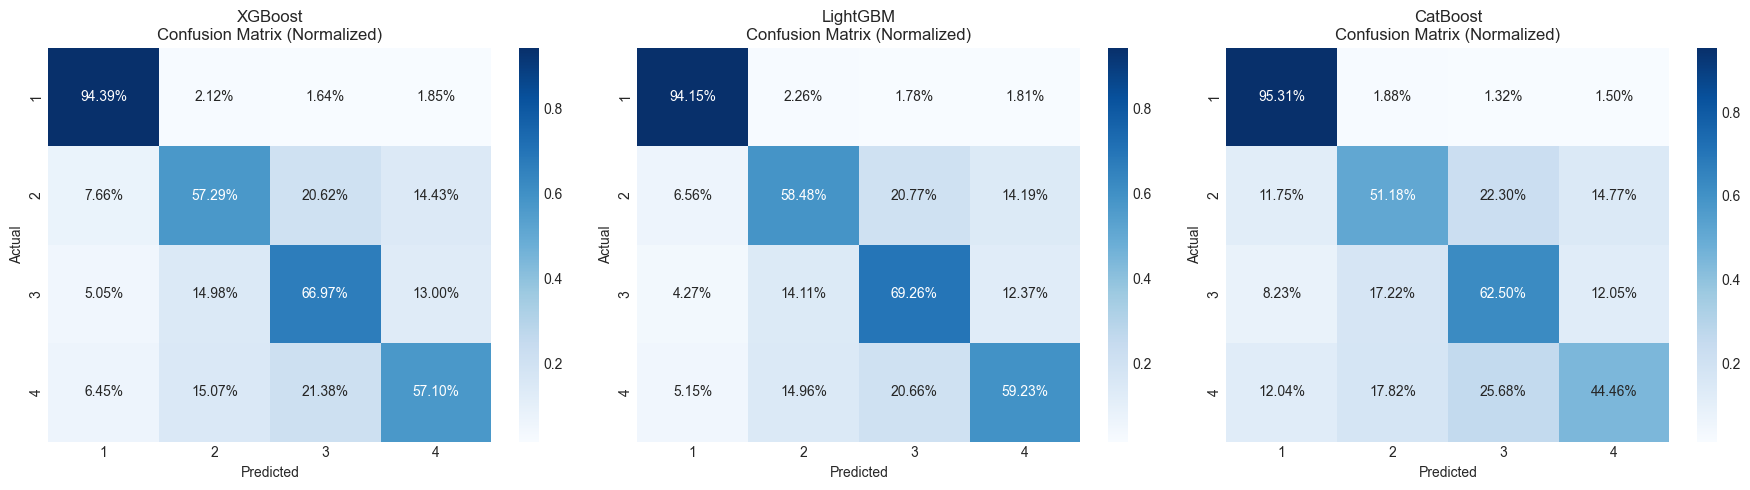

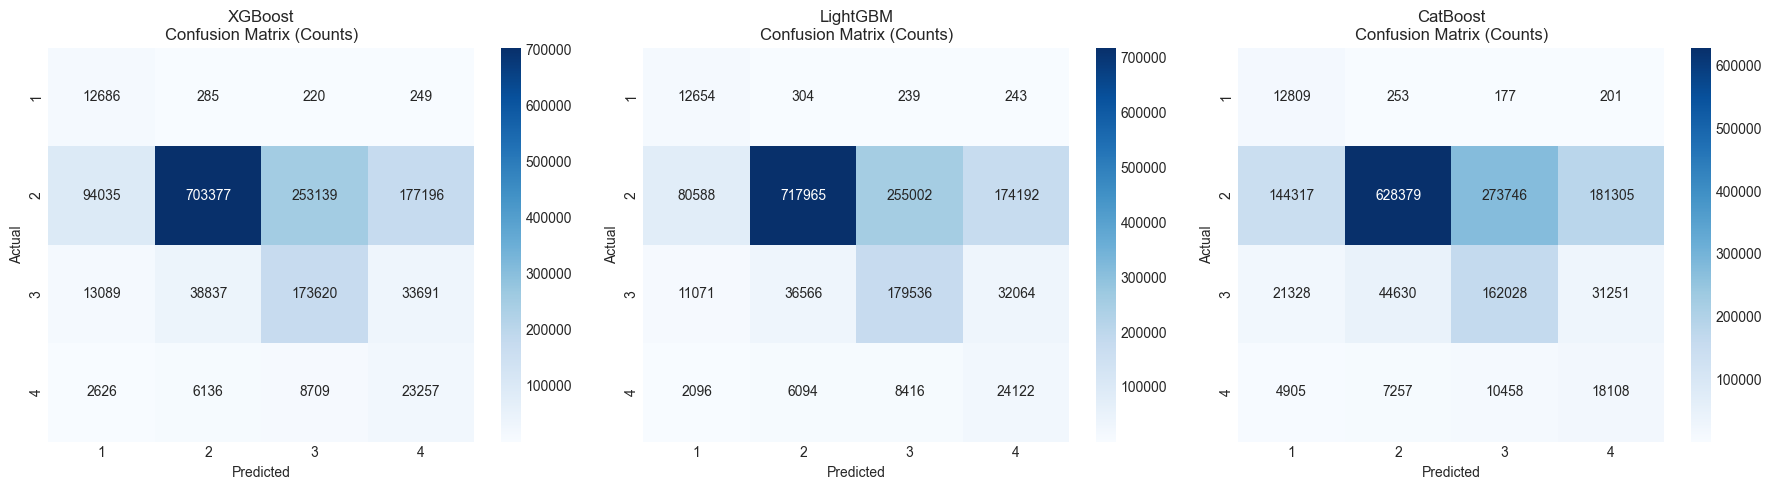

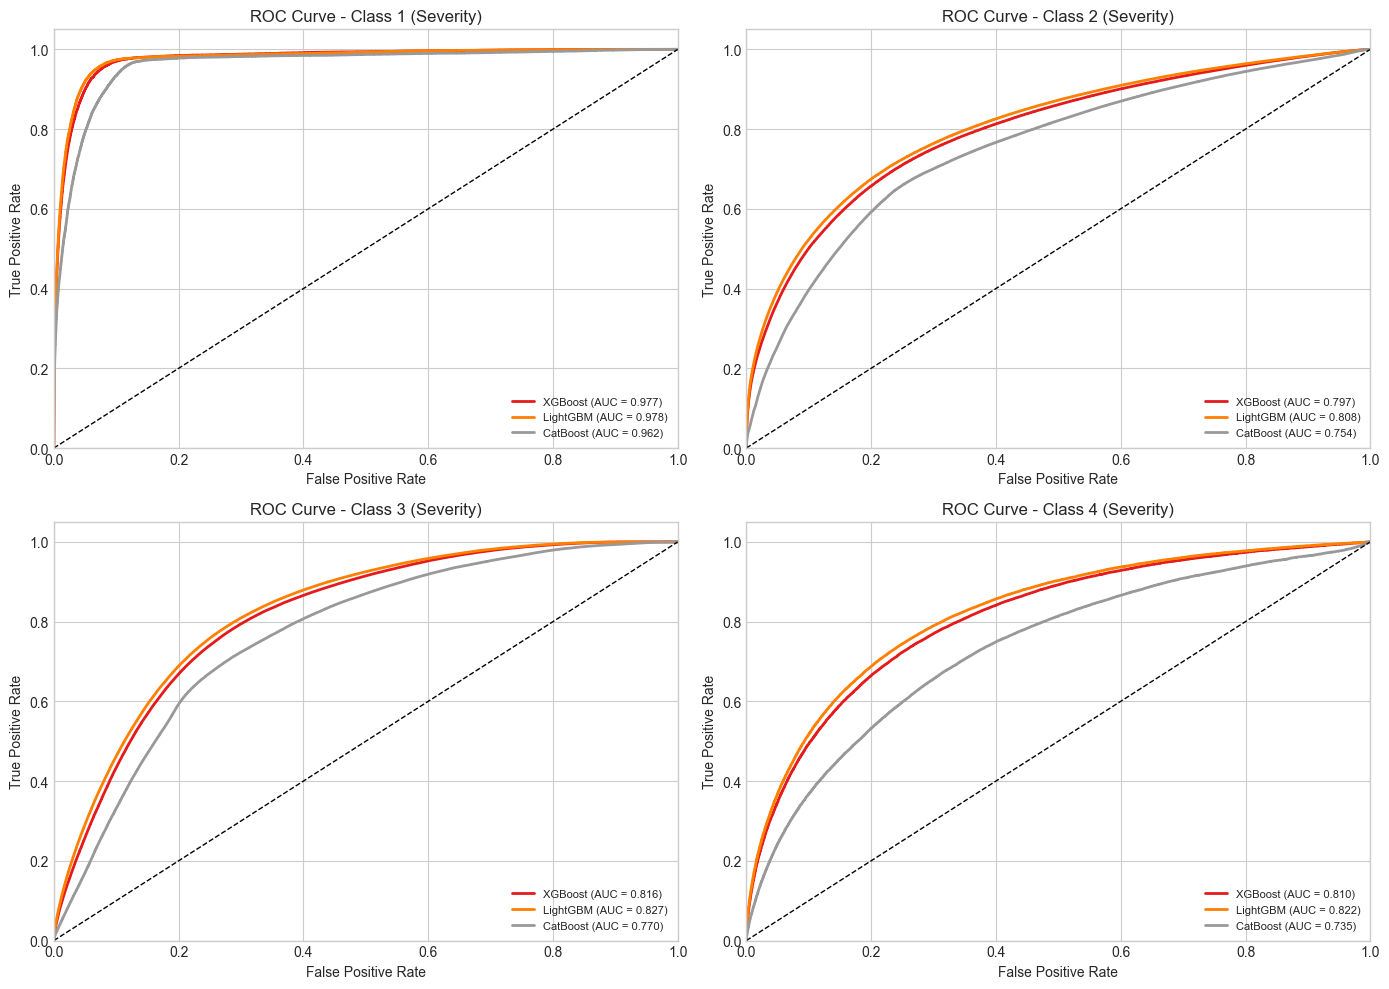

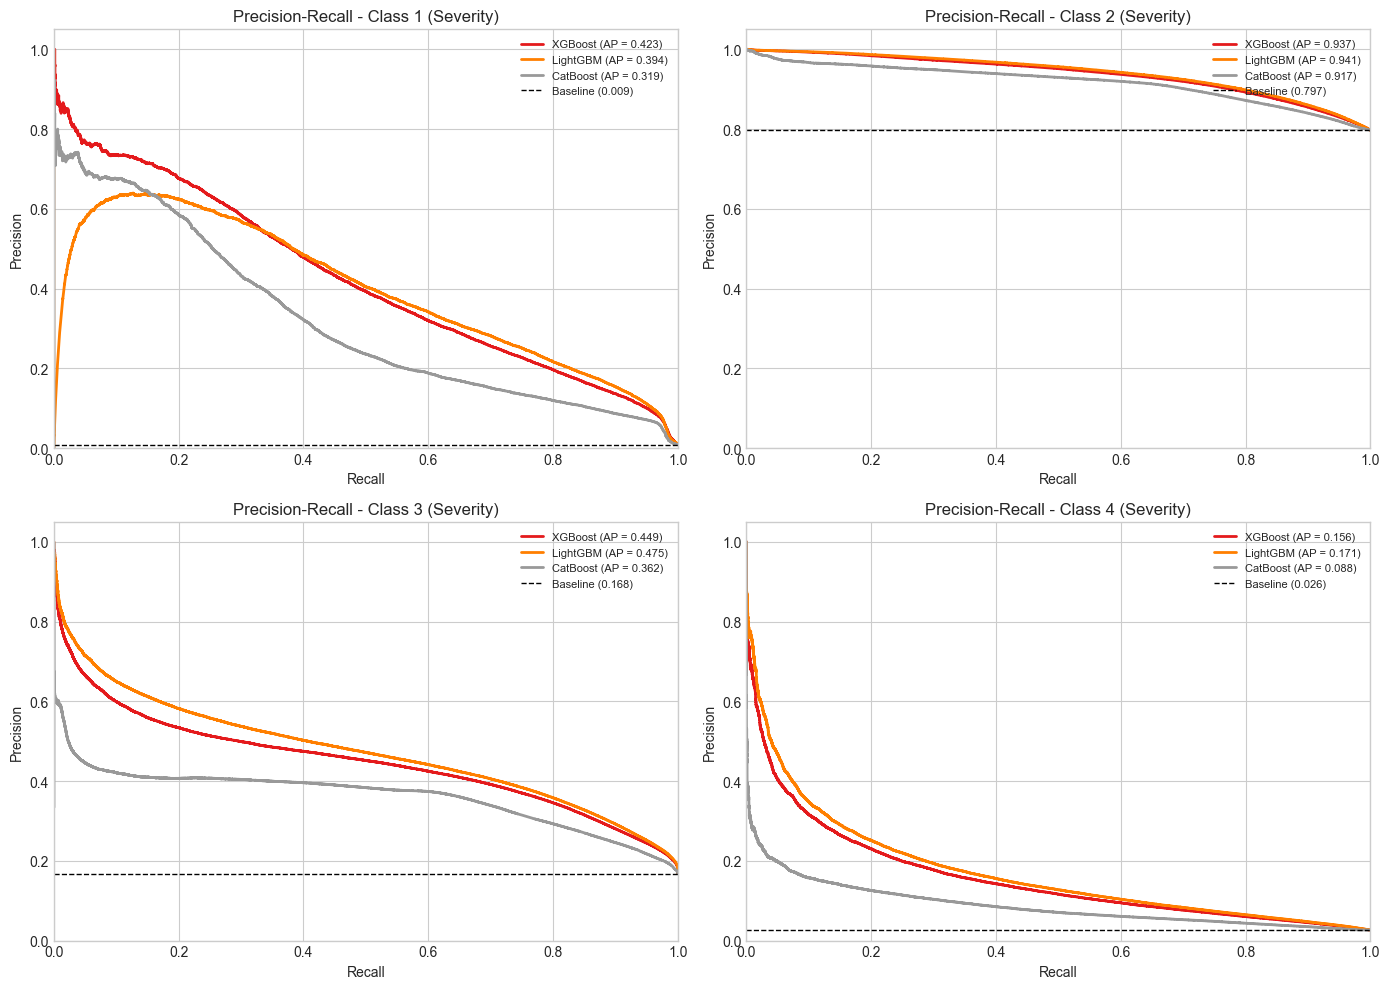

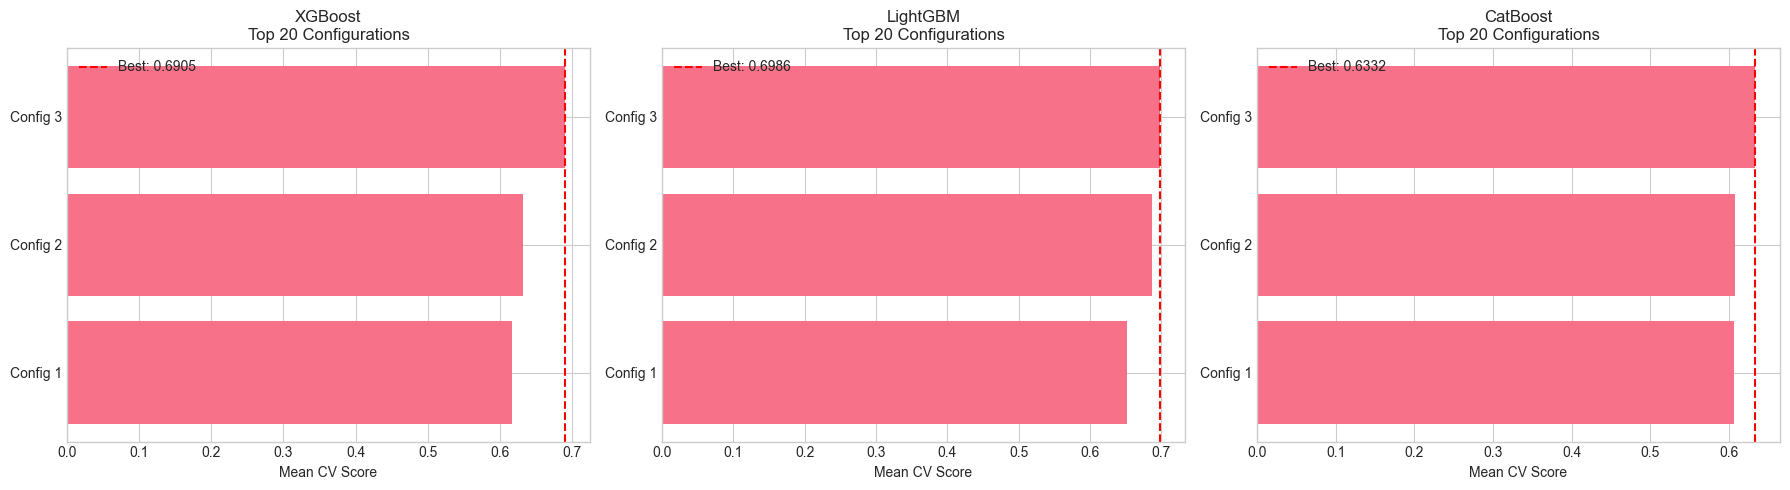

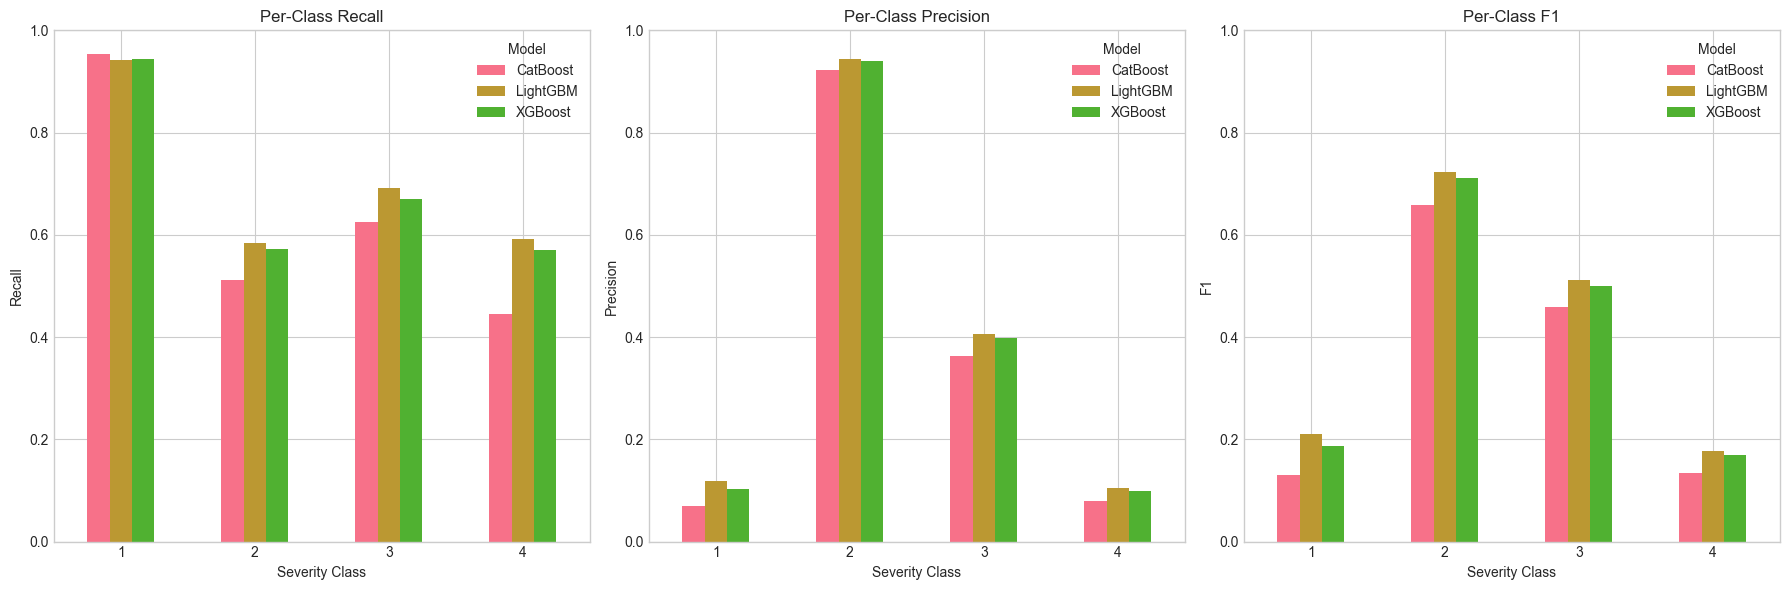


Class Support (Test Set):
  Class 1: 13,440
  Class 2: 1,227,747
  Class 3: 259,237
  Class 4: 40,728

🔍 STEP 7: SHAP Explainability Analysis

🔍 Running SHAP analysis for best model: LightGBM

SHAP ANALYSIS FOR LightGBM
Computing SHAP values for 1000 samples...

Generating summary plot for all classes...


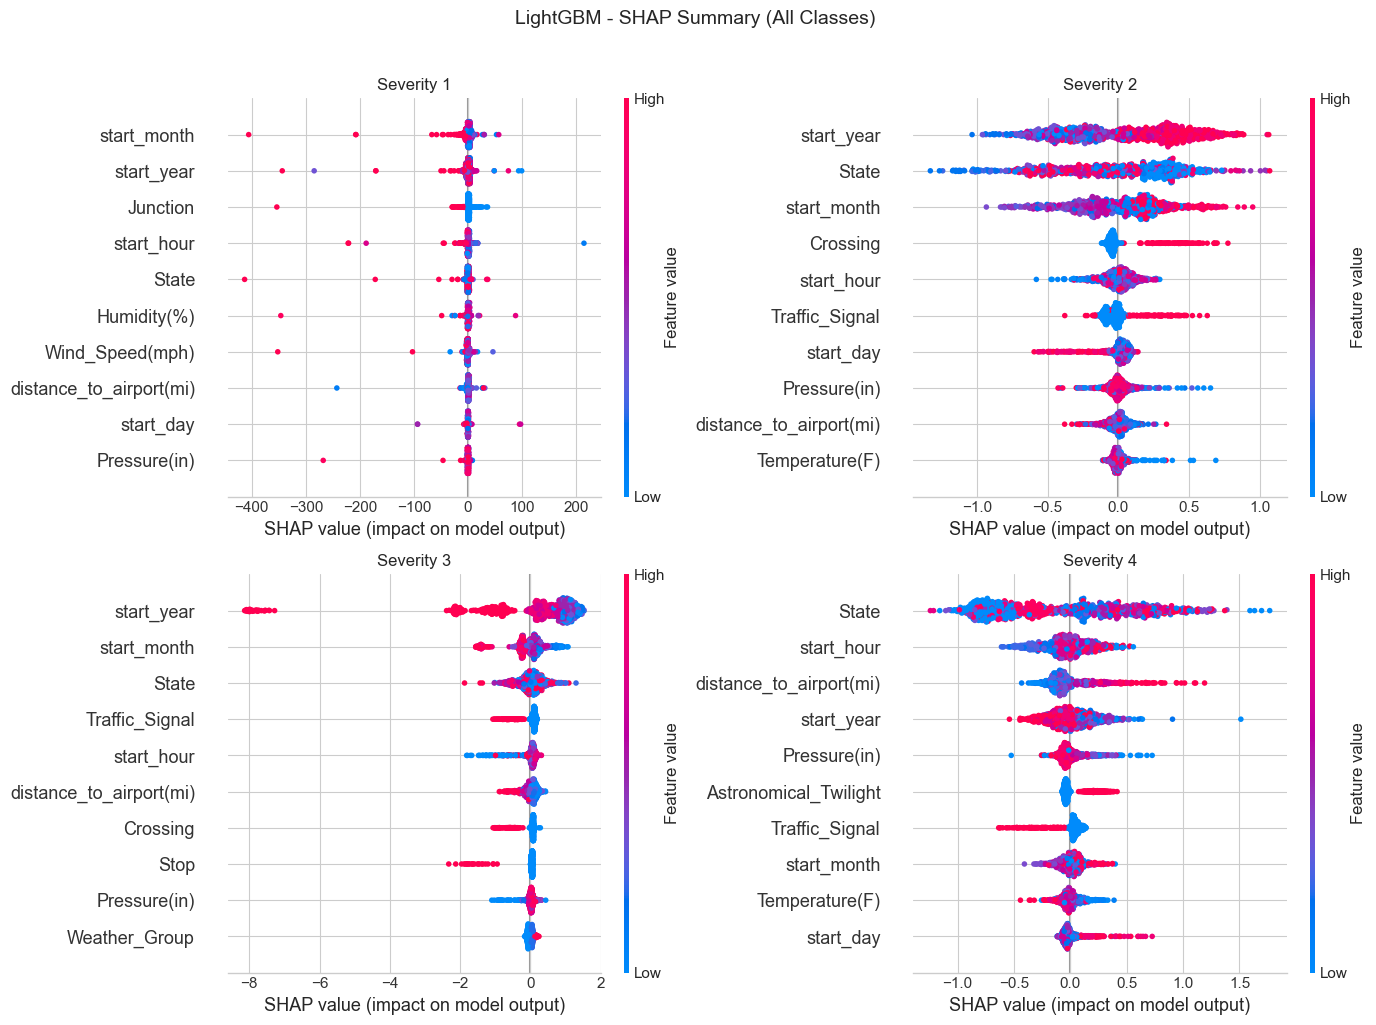


Generating detailed summary for high-severity classes...


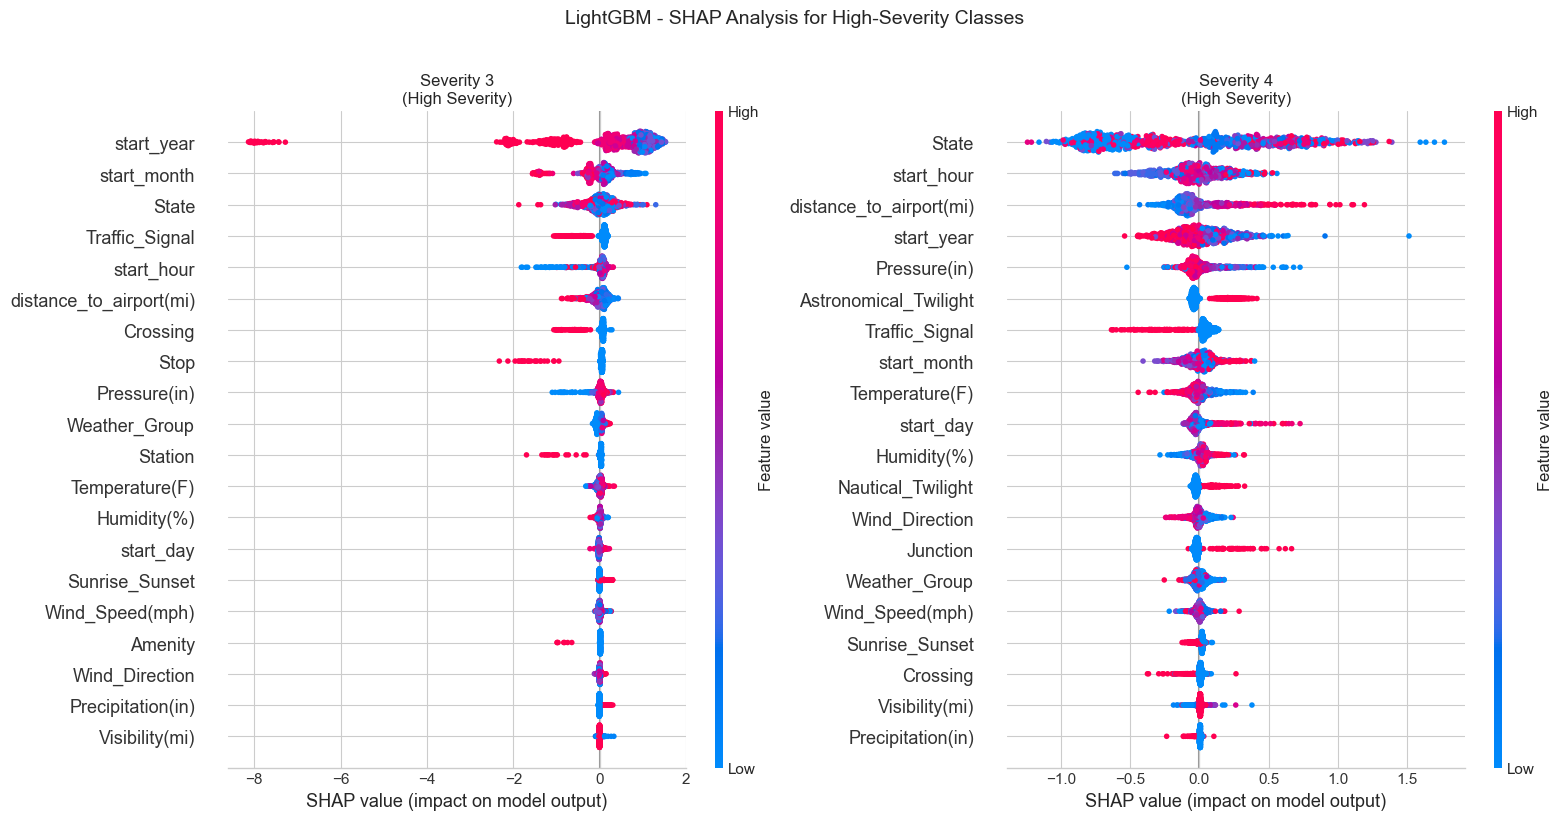


Generating feature importance comparison...


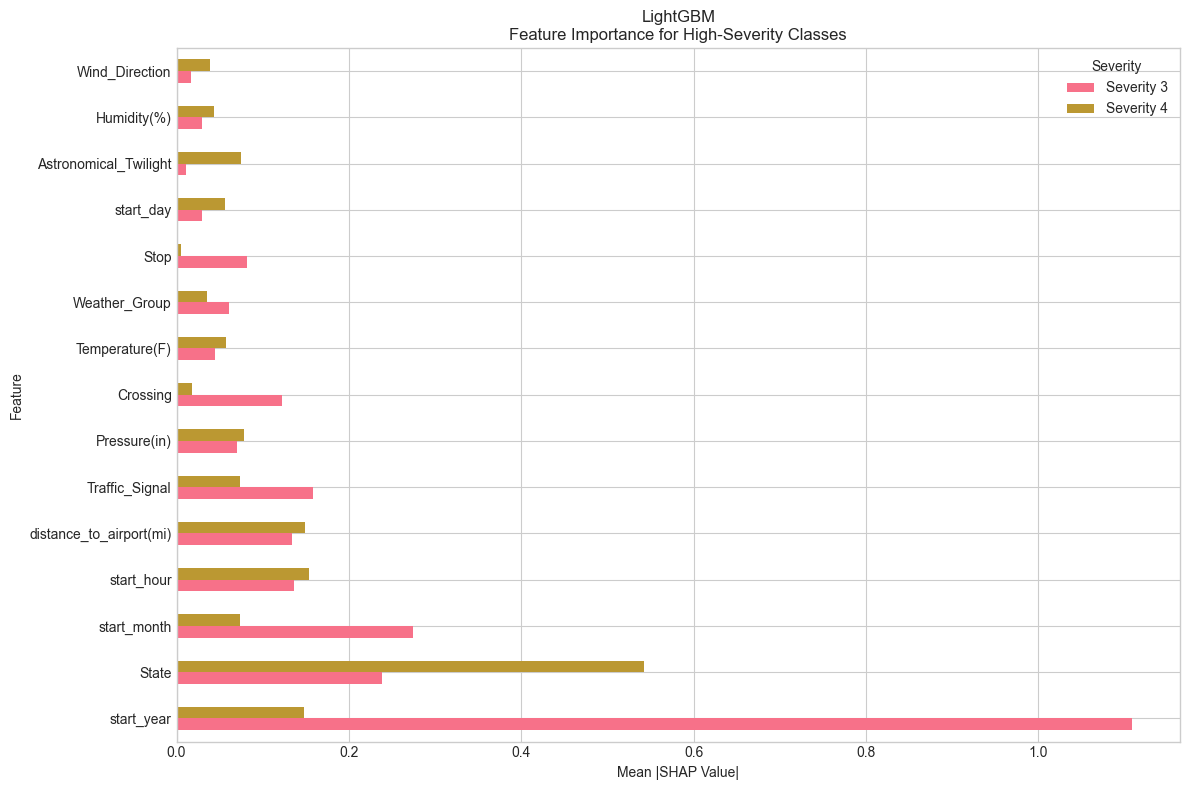


Generating dependence plots for high-severity classes...


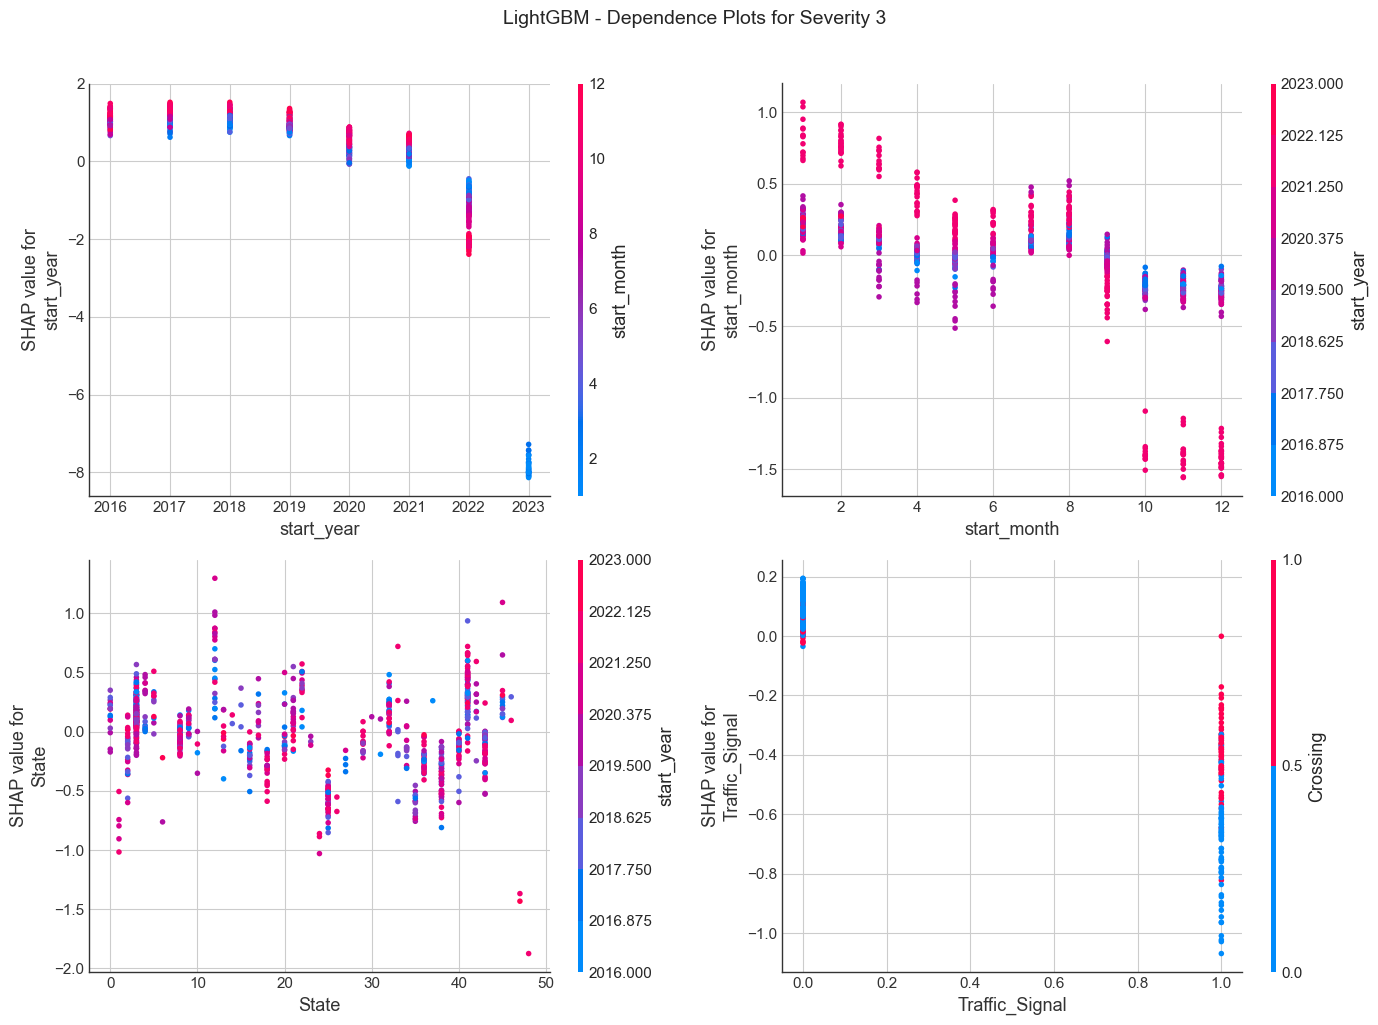

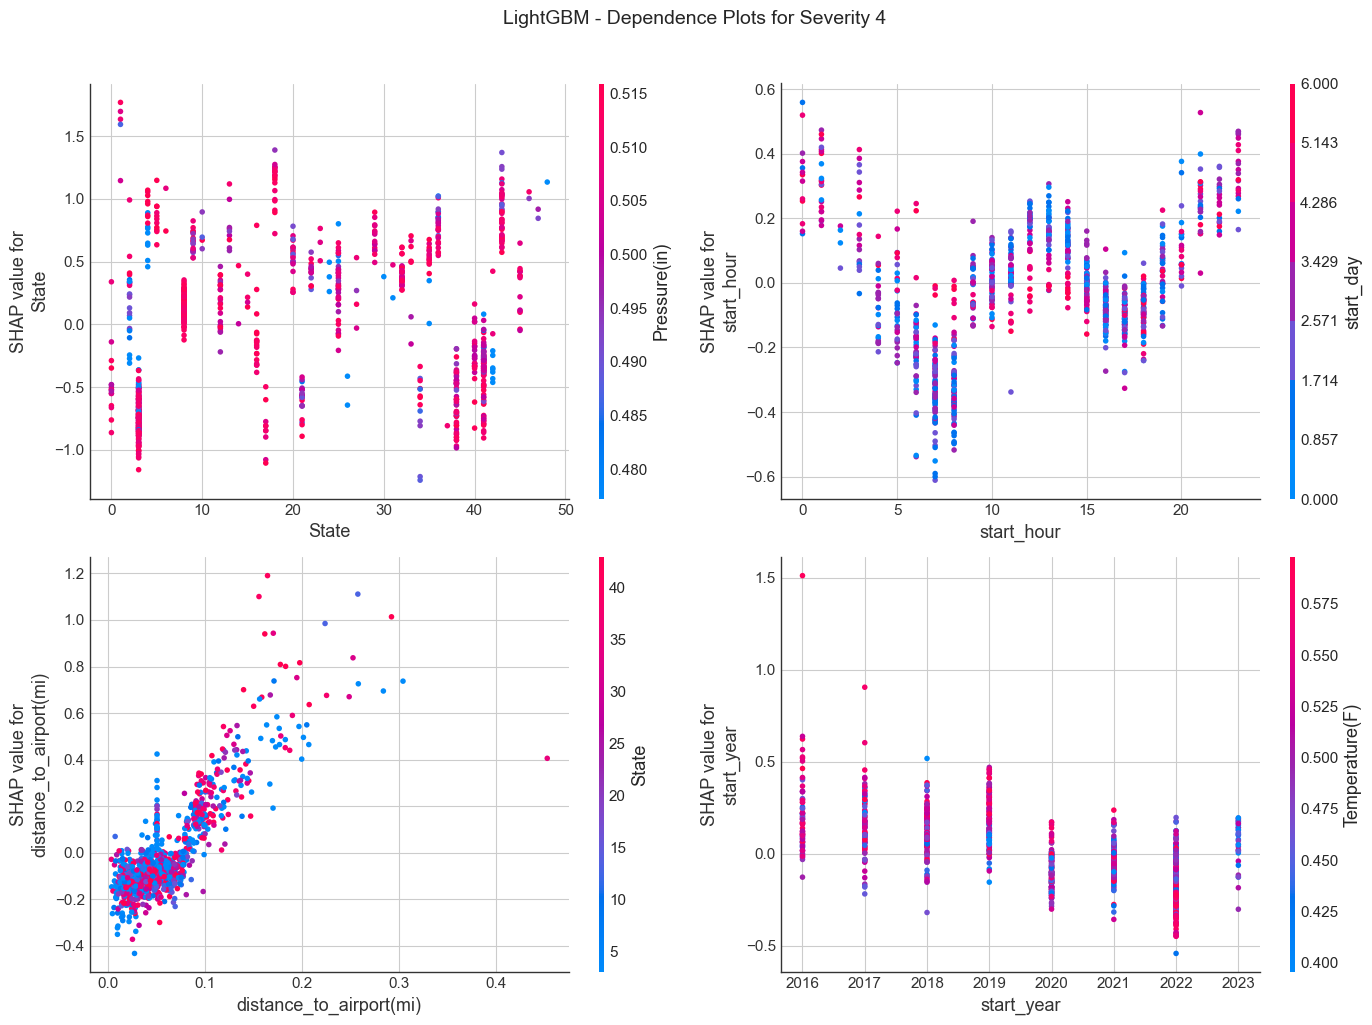


Generating decision plots for high-severity predictions...


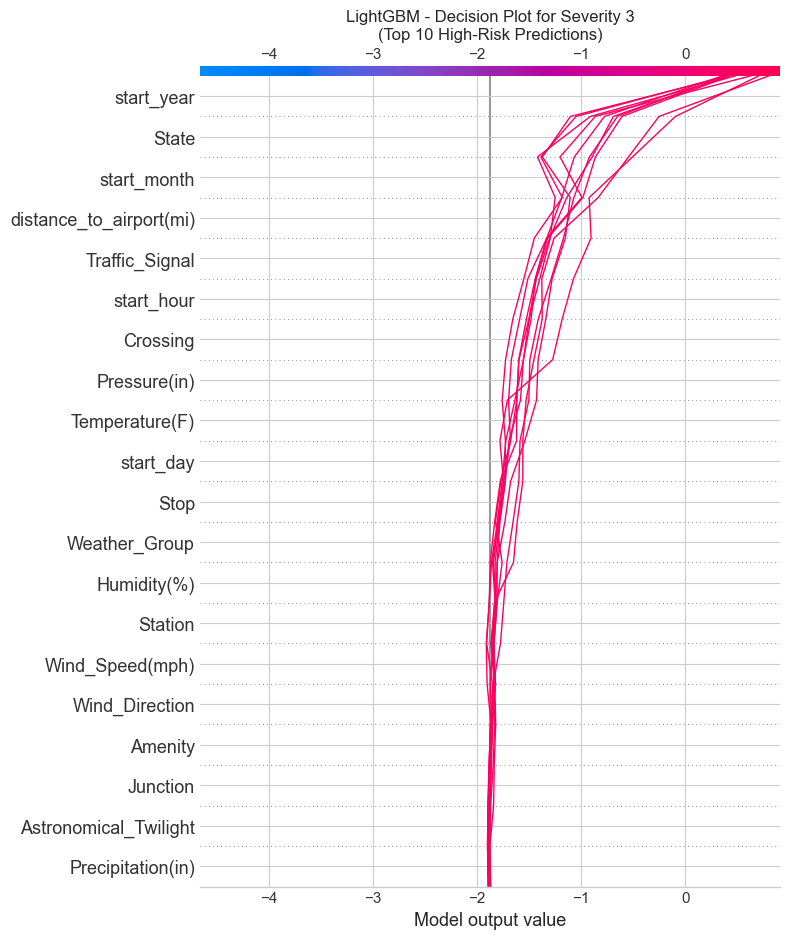

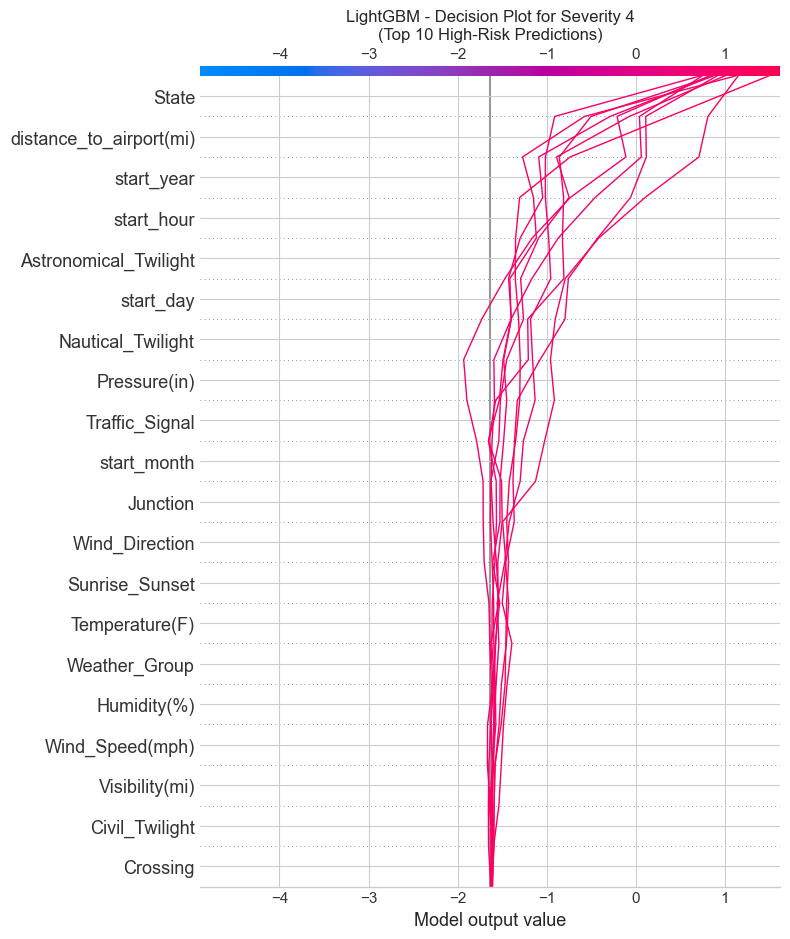


SHAP analysis complete!

📊 Top Features Contributing to High Severity (Classes 3 & 4):
Severity Class                 Feature  Mean |SHAP|  Mean SHAP      Direction
             3              start_year     1.108852   0.013343 Increases Risk
             3             start_month     0.274733  -0.032739 Decreases Risk
             3                   State     0.238686   0.005040 Increases Risk
             3          Traffic_Signal     0.158293   0.020588 Increases Risk
             3              start_hour     0.136044  -0.019969 Decreases Risk
             3 distance_to_airport(mi)     0.133574  -0.000576 Decreases Risk
             3                Crossing     0.122258   0.001073 Increases Risk
             3                    Stop     0.081586   0.004914 Increases Risk
             3            Pressure(in)     0.069802   0.001923 Increases Risk
             3           Weather_Group     0.060584  -0.001183 Decreases Risk
             4                   State     0.541895  -

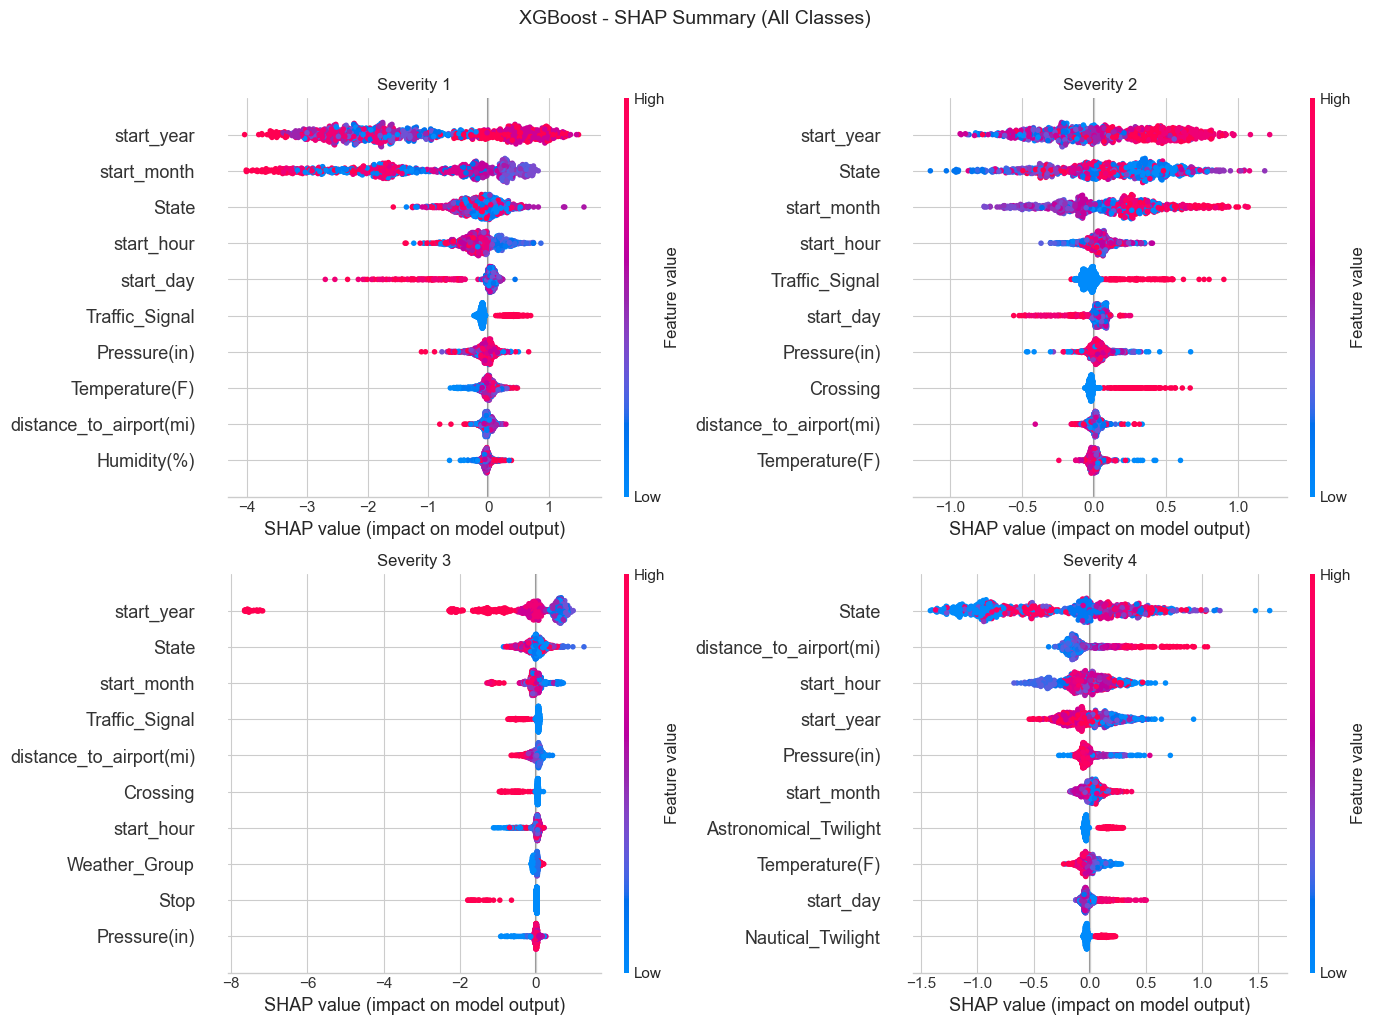


Generating detailed summary for high-severity classes...


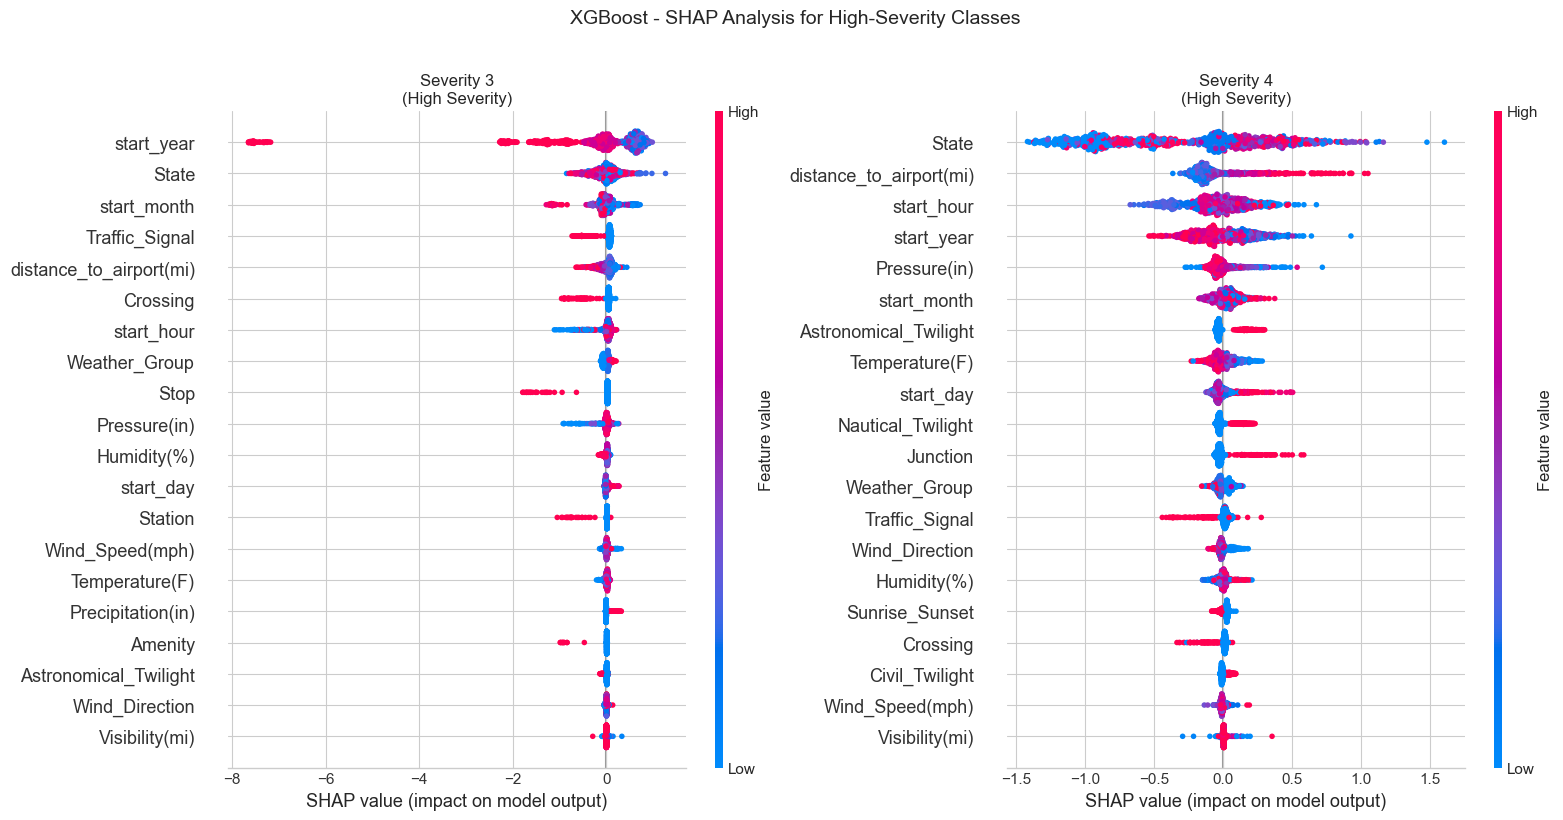


Generating feature importance comparison...


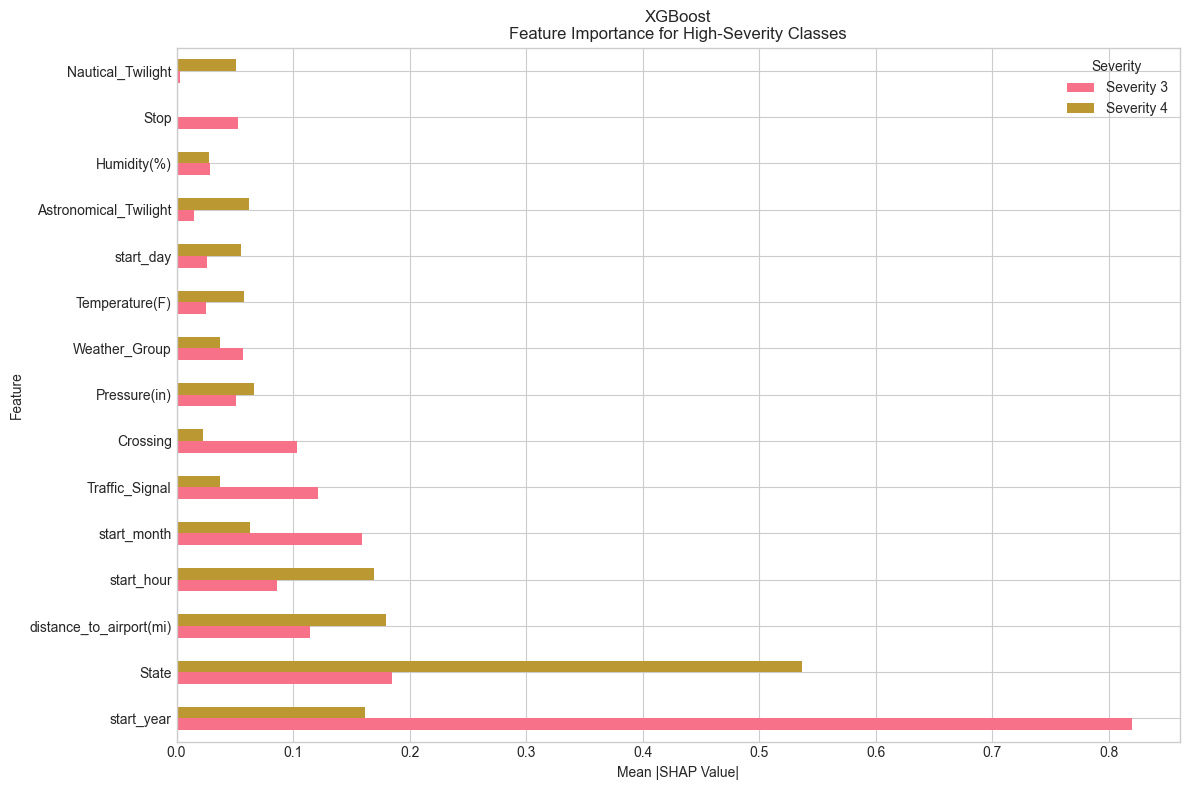


Generating dependence plots for high-severity classes...


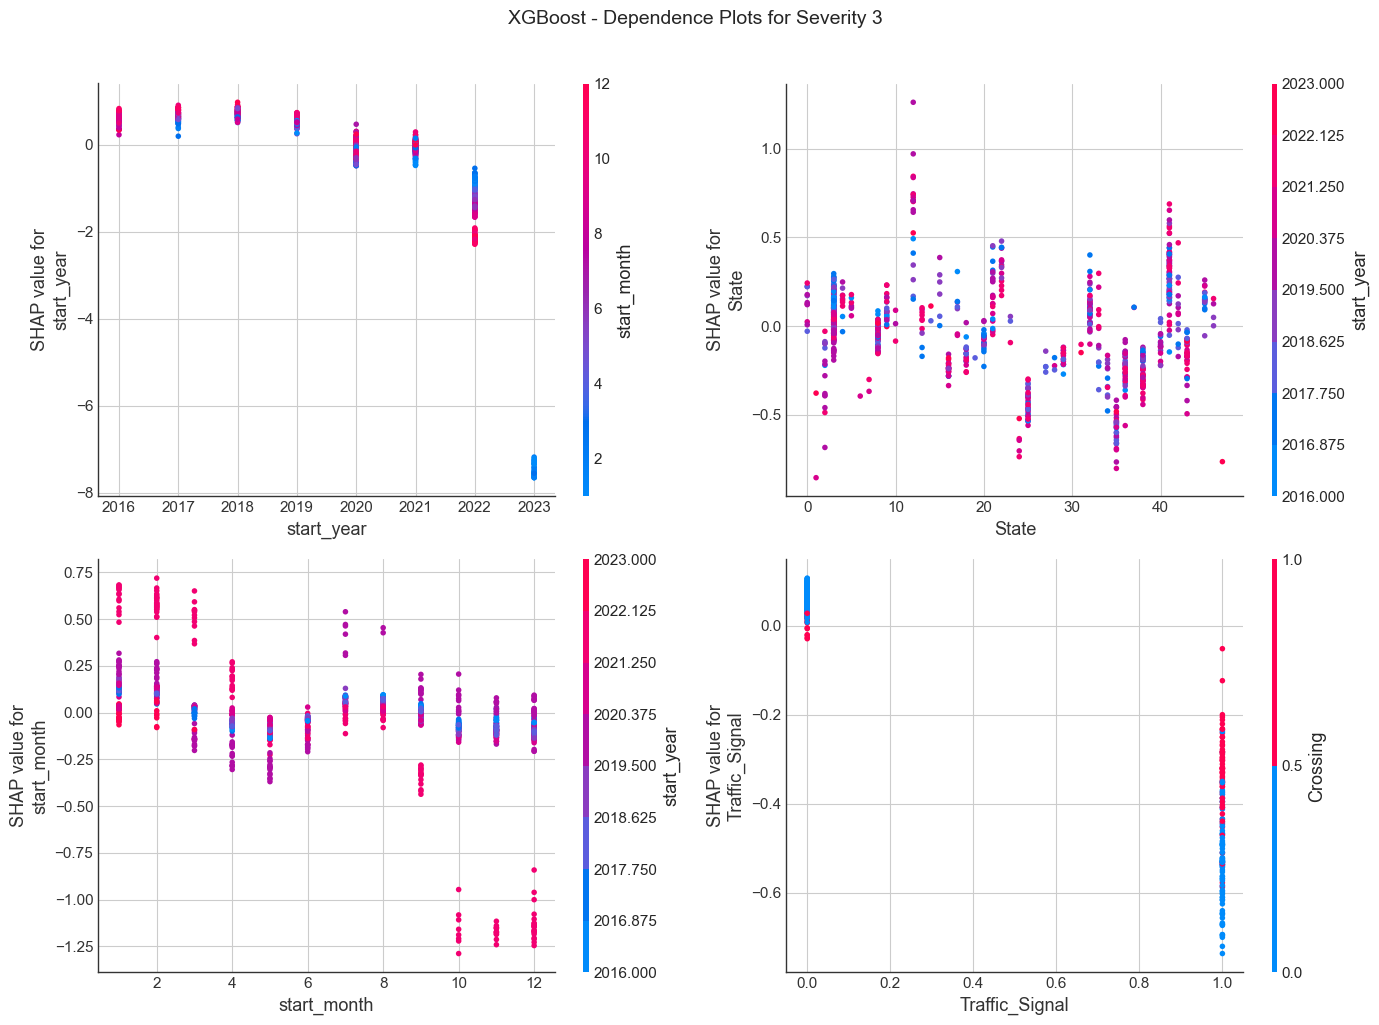

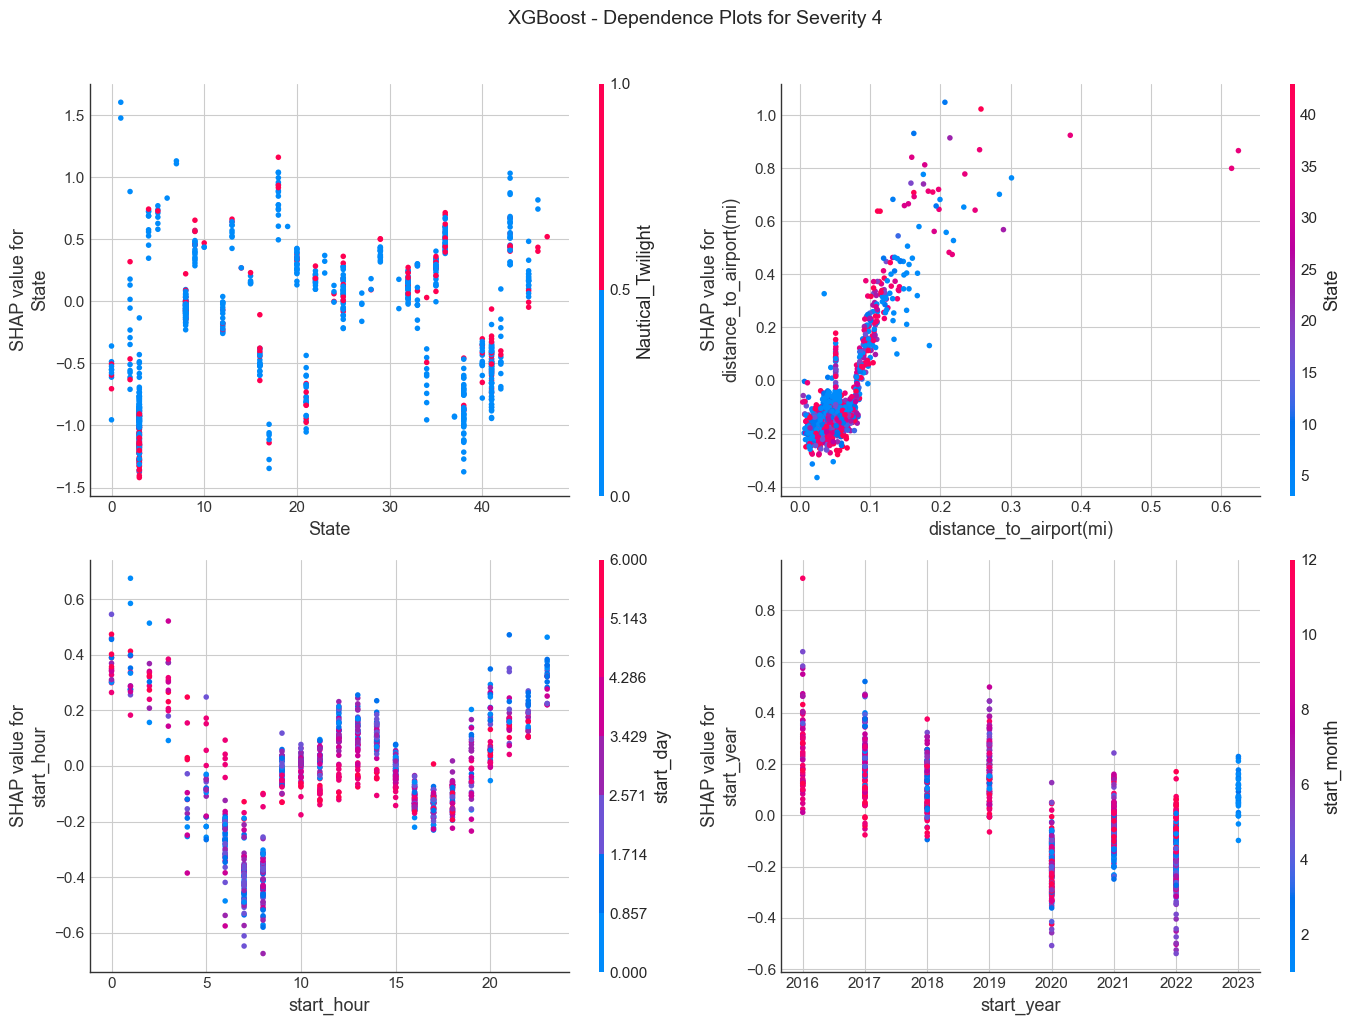


Generating decision plots for high-severity predictions...


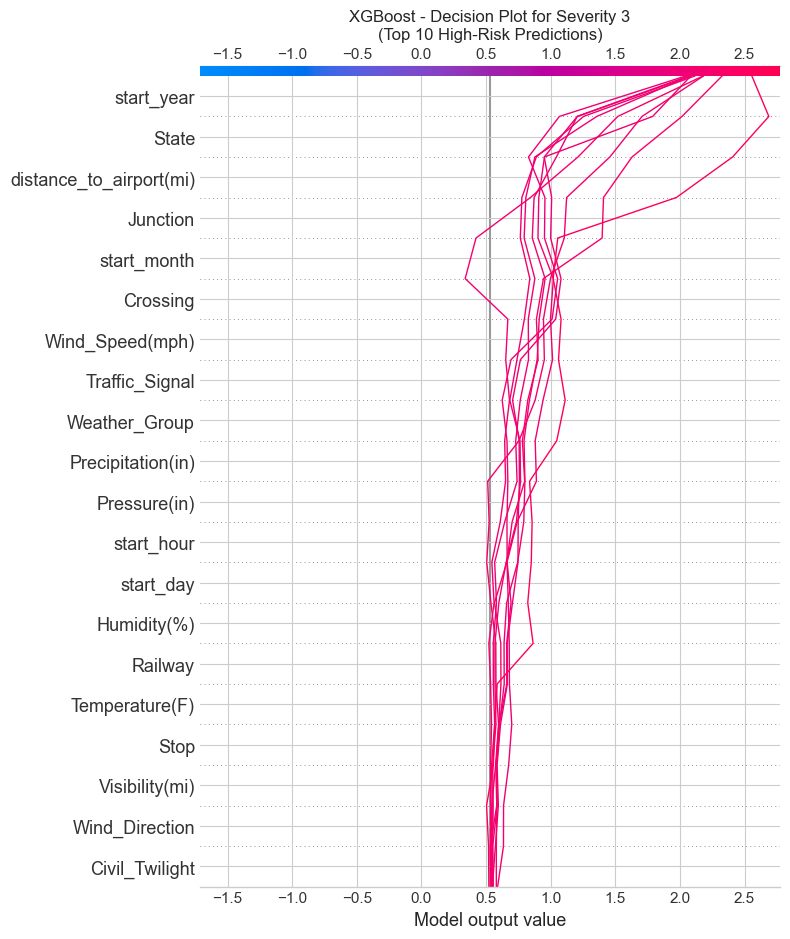

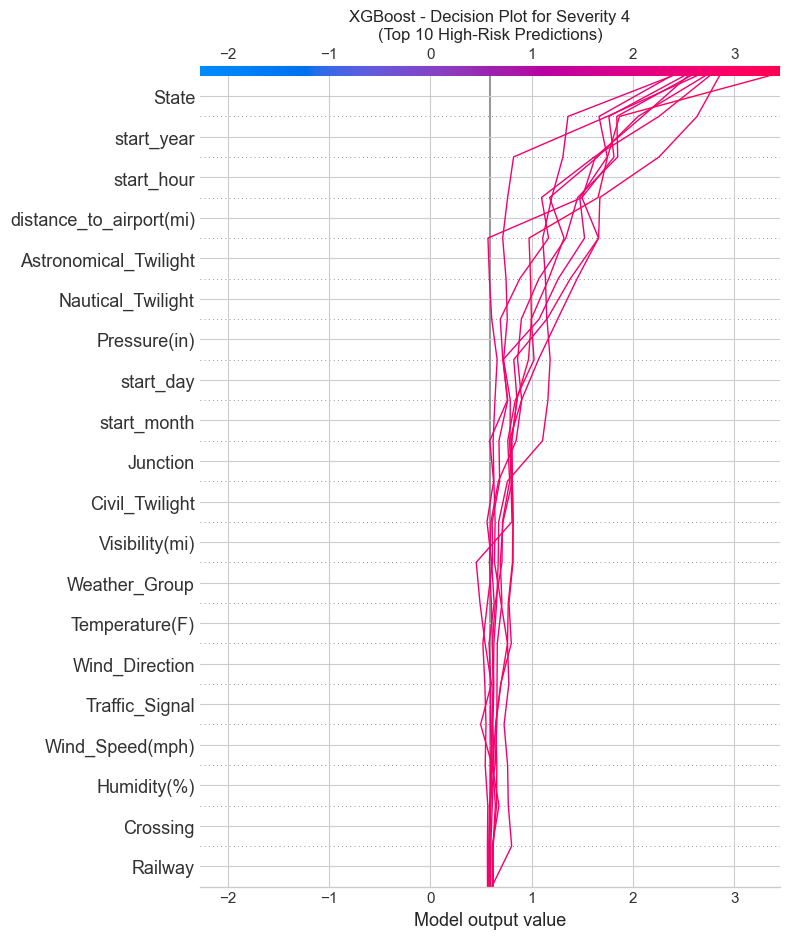


SHAP analysis complete!

🔍 Running SHAP analysis for: CatBoost

SHAP ANALYSIS FOR CatBoost
Computing SHAP values for 1000 samples...

Generating summary plot for all classes...


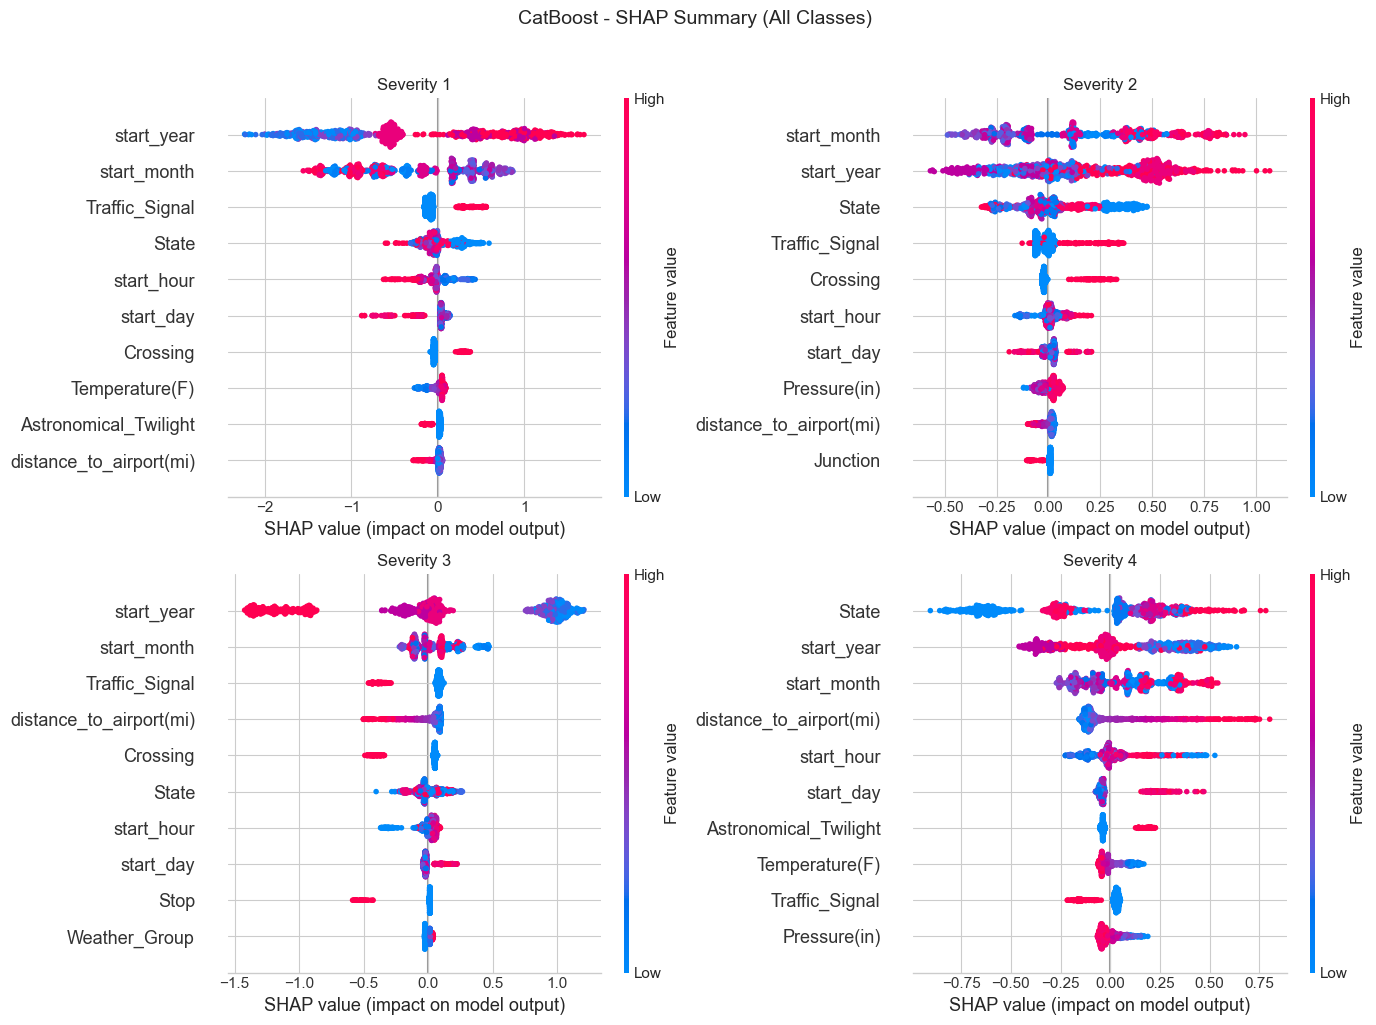


Generating detailed summary for high-severity classes...


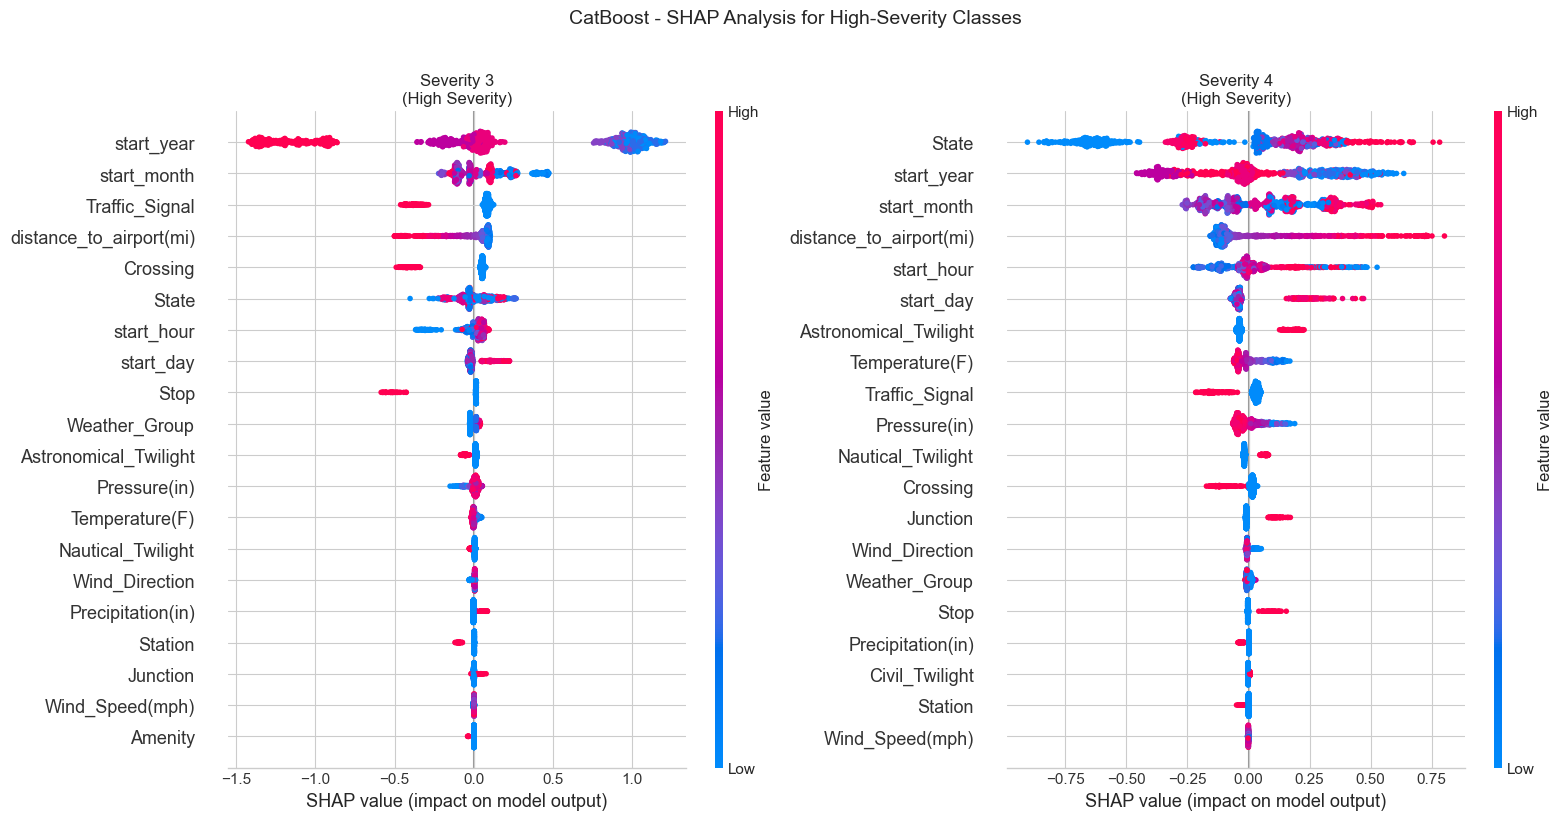


Generating feature importance comparison...


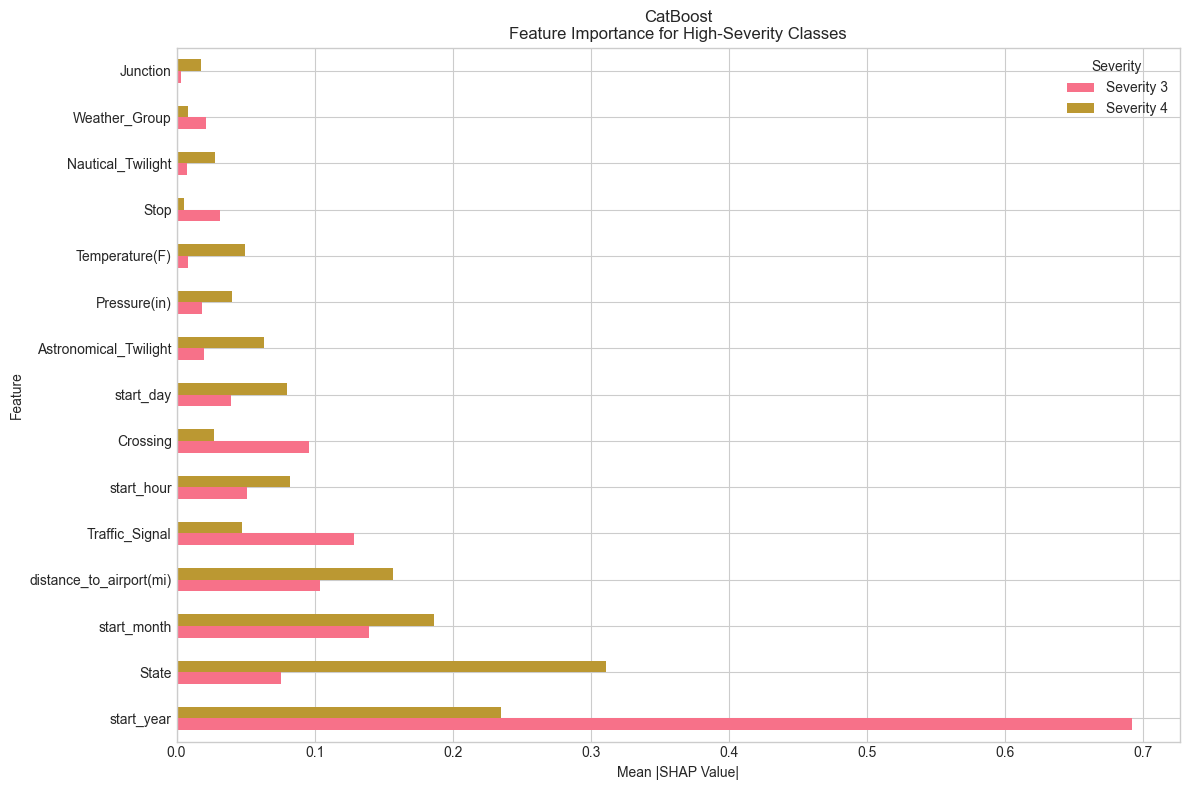


Generating dependence plots for high-severity classes...


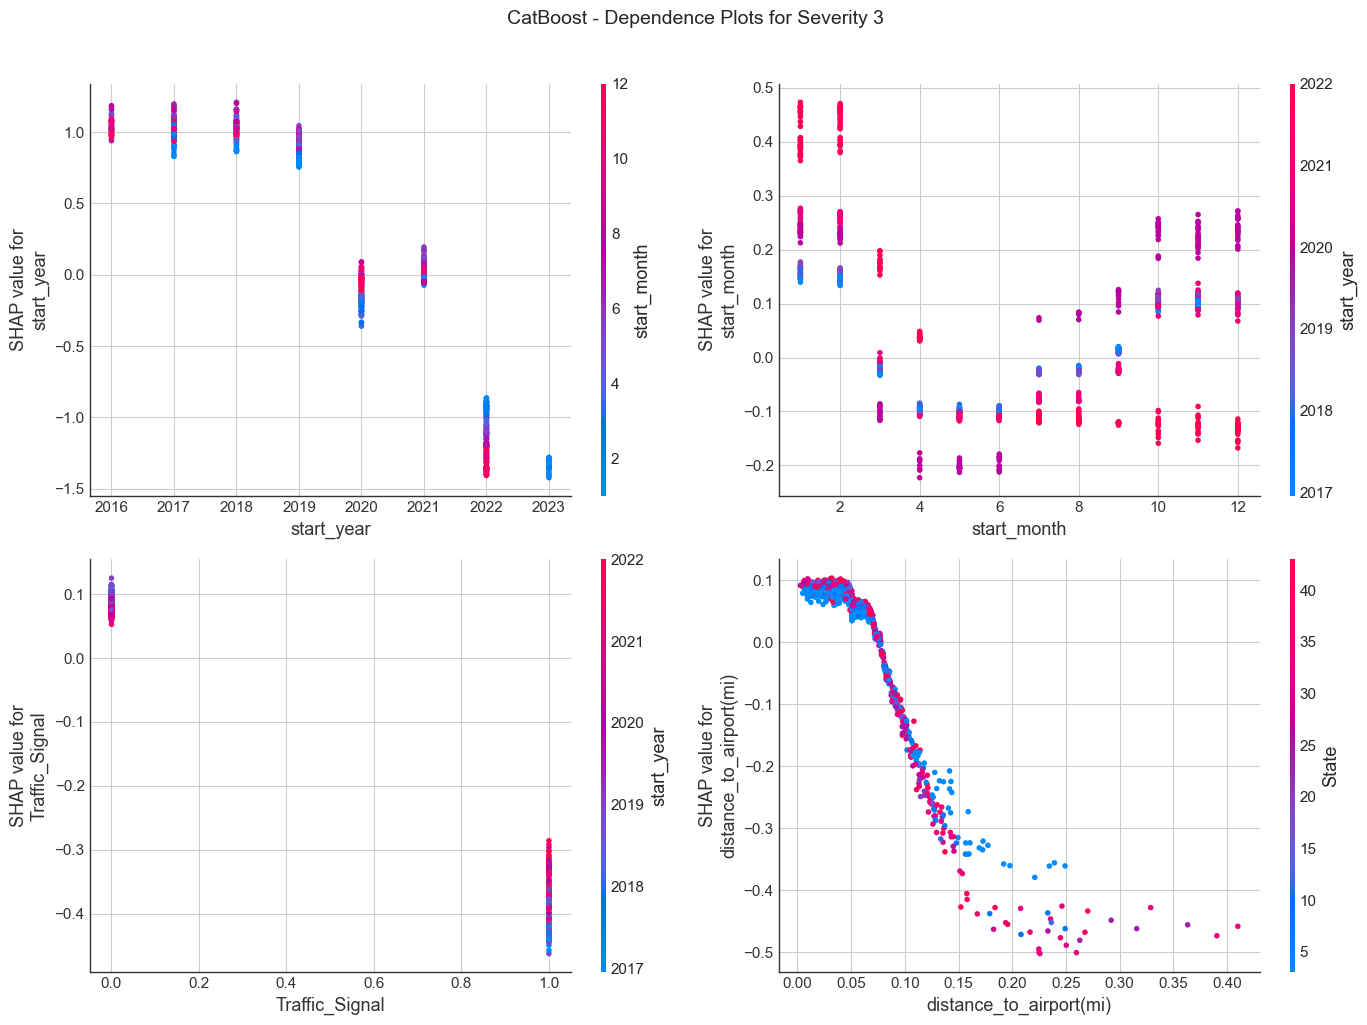

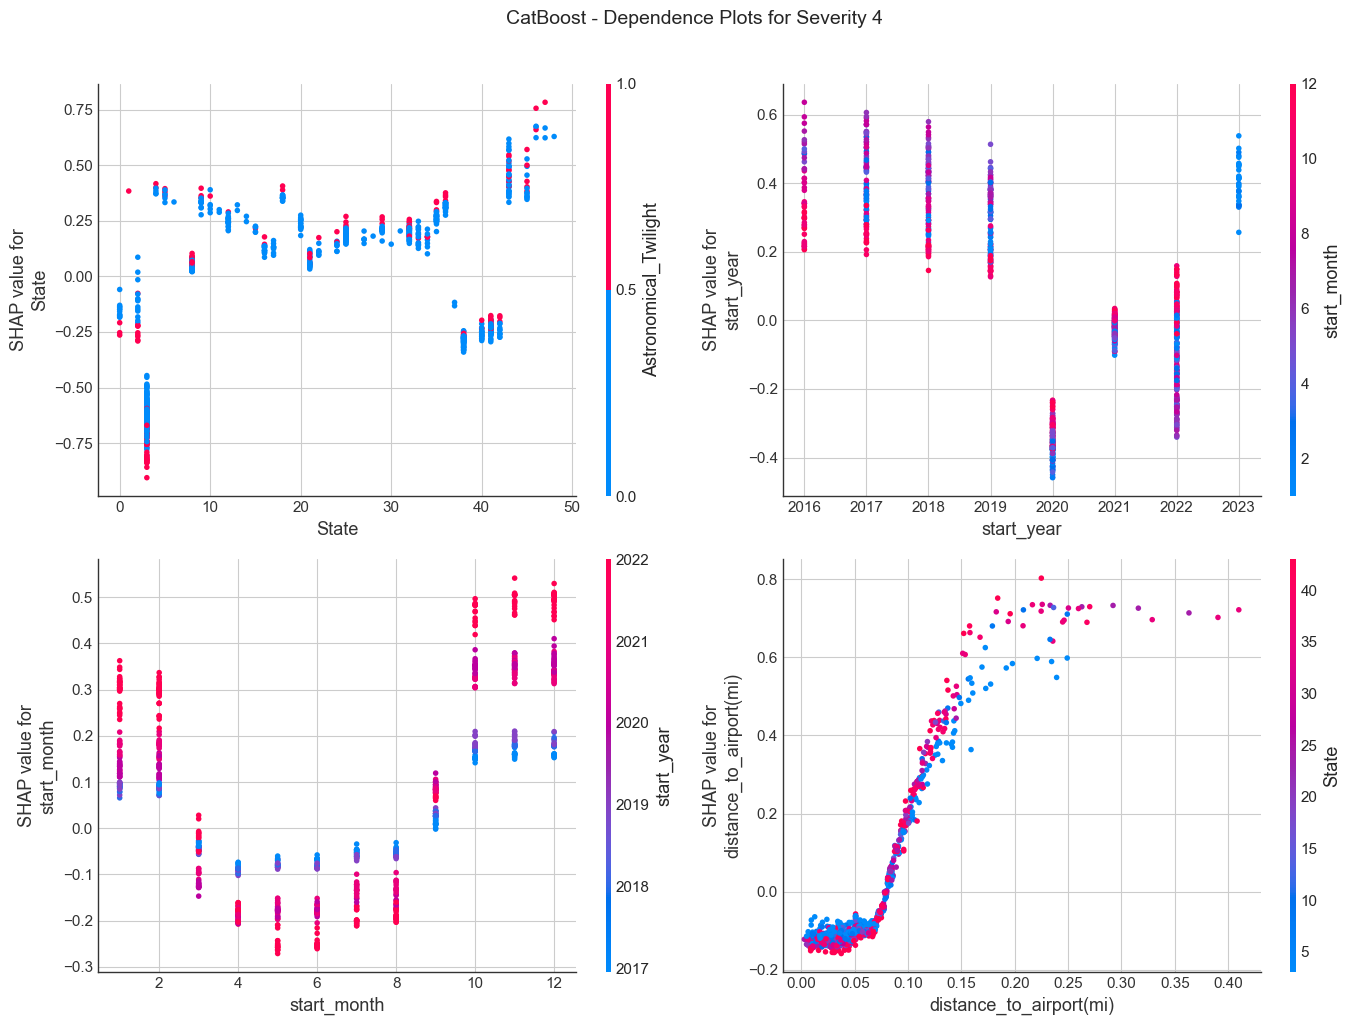


Generating decision plots for high-severity predictions...


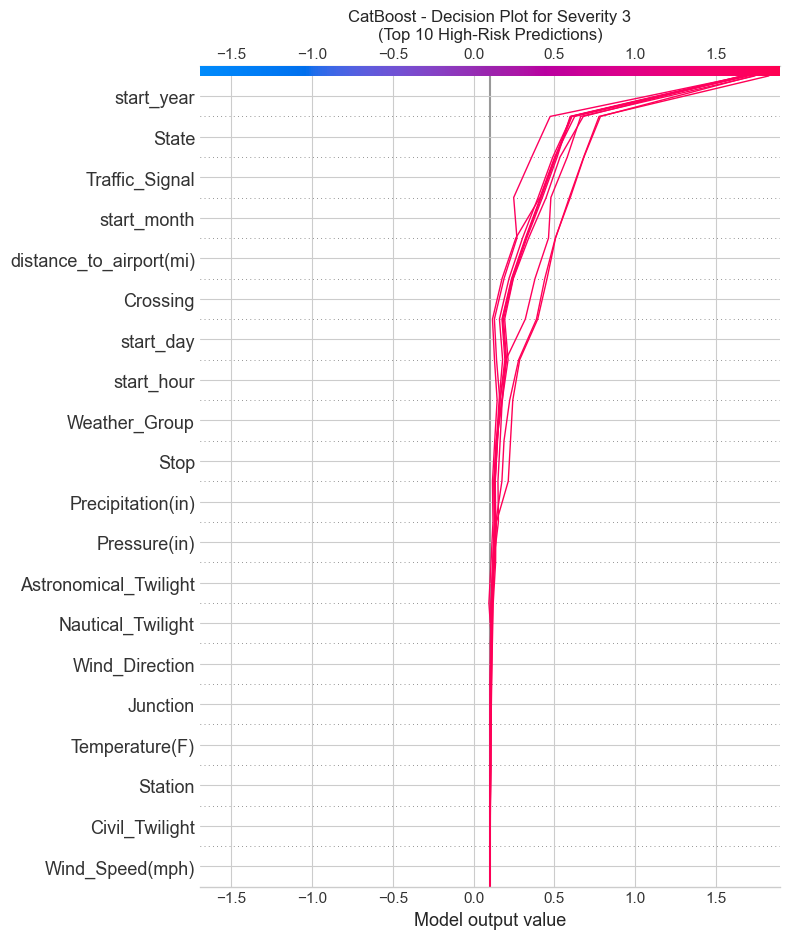

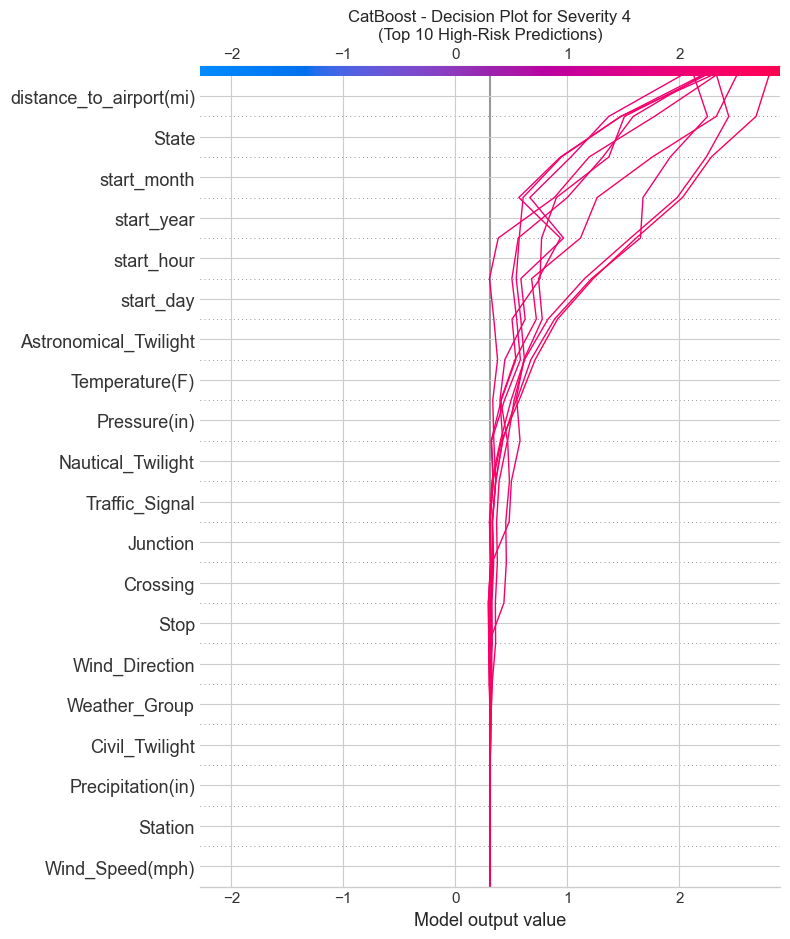


SHAP analysis complete!

PIPELINE COMPLETE!

🏆 Best Model: LightGBM
   Balanced Accuracy: 0.7028
   Macro F1: 0.4055


In [24]:
# Initialize pipeline
pipeline = MLPipeline(config)

# Run complete pipeline with SHAP analysis
# focus_severity_classes=[2, 3] corresponds to Severity 3 and 4 (0-indexed)
results = pipeline.run_complete_pipeline(
    df,
    run_shap=True,
    focus_severity_classes=[2, 3]  # Focus SHAP on high severity (3 & 4)
)

In [29]:
results

{'trained_models': {'XGBoost': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('num',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='median')),
                                                                    ('scaler',
                                                                     MinMaxScaler())]),
                                                    ['Temperature(F)',
                                                     'Humidity(%)',
                                                     'Pressure(in)',
                                                     'Visibility(mi)',
                                                     'Wind_Speed(mph)',
                                                     'Precipitation(in)',
                                                     'distance_to_airport(mi)']),
                   

In [31]:
# Access different components of the results

# Best model
best_model_name = results['best_model_name']
best_model = results['best_model']
print(f"🏆 Best Model: {best_model_name}")

# Evaluation results
evaluation_df = results['evaluation_results']
display_cols = [col for col in evaluation_df.columns if not col.startswith('_')]
print("\n📊 Test Set Evaluation:")
print(evaluation_df[display_cols])

# Cross-validation summary
cv_summary = results['cv_summary']
print("\n📈 CV Summary:")
print(cv_summary)

# Best parameters for each model
print("\n⚙️ Best Parameters:")
for model_name, search_result in results['search_results'].items():
    print(f"\n{model_name}:")
    for param, value in search_result['best_params'].items():
        print(f"  {param.replace('classifier__', '')}: {value}")

🏆 Best Model: LightGBM

📊 Test Set Evaluation:
         Balanced Accuracy Macro Precision Macro Recall  Macro F1 Weighted F1  \
LightGBM          0.702782        0.393037     0.702782  0.405549    0.667745   
XGBoost           0.689392        0.385219     0.689392  0.391815    0.657184   
CatBoost          0.633623        0.358658     0.633623  0.345335    0.606565   

               MCC ROC-AUC (OvR) ROC-AUC (OvO)  
LightGBM  0.343087      0.858677      0.894902  
XGBoost   0.326355      0.849929      0.888186  
CatBoost  0.265614      0.804879       0.85085  

📈 CV Summary:
      Model  Best CV Score  Mean Train Score  Std CV Score  Mean Fit Time (s)
1  LightGBM       0.698551          0.740718      0.000437         834.934785
0   XGBoost       0.690512          0.706920      0.000029         667.170324
2  CatBoost       0.633236          0.633742      0.000155         839.912009

⚙️ Best Parameters:

XGBoost:
  colsample_bytree: 0.749816047538945
  gamma: 0.4753571532049581
  learni

In [32]:
y_pred = best_model.predict(pipeline.X_test)
y_proba = best_model.predict_proba(pipeline.X_test)

print(f"Predictions shape: {y_pred.shape}")
print(f"Probabilities shape: {y_proba.shape}")

# Decode predictions back to original labels
label_encoder = results['label_encoder']
y_pred_decoded = label_encoder.inverse_transform(y_pred)
print(f"\nPrediction distribution:")
print(pd.Series(y_pred_decoded).value_counts())

Predictions shape: (1541152,)
Probabilities shape: (1541152, 4)

Prediction distribution:
2    760929
3    443193
4    230621
1    106409
Name: count, dtype: int64


In [33]:
import joblib
import json
from datetime import datetime

# Create output directory
import os
output_dir = os.path.join('..', 'artifacts')
os.makedirs(output_dir, exist_ok=True)

# Save best model
model_filename = f'{output_dir}/best_model_{best_model_name.lower().replace(" ", "_")}.joblib'
joblib.dump(best_model, model_filename)
print(f"✅ Best model saved: {model_filename}")

# Save all trained models
for model_name, model in results['trained_models'].items():
    filename = f'{output_dir}/model_{model_name.lower().replace(" ", "_")}.joblib'
    joblib.dump(model, filename)
    print(f"✅ Model saved: {filename}")

# Save label encoder
joblib.dump(label_encoder, f'{output_dir}/label_encoder.joblib')
print(f"✅ Label encoder saved: {output_dir}/label_encoder.joblib")

# Save evaluation results
evaluation_df[display_cols].to_csv(f'{output_dir}/evaluation_results.csv')
print(f"✅ Evaluation results saved: {output_dir}/evaluation_results.csv")

# Save configuration
config_dict = {
    'TEST_SIZE': config.TEST_SIZE,
    'CV_FOLDS': config.CV_FOLDS,
    'N_ITER_SEARCH': config.N_ITER_SEARCH,
    'SCORING_METRIC': config.SCORING_METRIC,
    'RANDOM_STATE': config.RANDOM_STATE,
    'timestamp': datetime.now().isoformat()
}
with open(f'{output_dir}/config.json', 'w') as f:
    json.dump(config_dict, f, indent=2)
print(f"✅ Configuration saved: {output_dir}/config.json")

✅ Best model saved: ..\artifacts/best_model_lightgbm.joblib
✅ Model saved: ..\artifacts/model_xgboost.joblib
✅ Model saved: ..\artifacts/model_lightgbm.joblib
✅ Model saved: ..\artifacts/model_catboost.joblib
✅ Label encoder saved: ..\artifacts/label_encoder.joblib
✅ Evaluation results saved: ..\artifacts/evaluation_results.csv
✅ Configuration saved: ..\artifacts/config.json


In [34]:
# Load saved model
loaded_model = joblib.load(f'{output_dir}/best_model_{best_model_name.lower().replace(" ", "_")}.joblib')
loaded_encoder = joblib.load(f'{output_dir}/label_encoder.joblib')

# Make predictions
# y_new = loaded_model.predict(new_data)
# y_new_decoded = loaded_encoder.inverse_transform(y_new)

print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [35]:
def run_shap_for_model(model, model_name, X_train, X_test, label_encoder, feature_names, focus_classes=[2, 3]):
    """Run SHAP analysis for a specific model."""
    
    shap_explainer = SHAPExplainer(
        label_encoder,
        feature_names,
        Config()
    )
    
    shap_explainer.explain_model(
        model,
        X_train,
        X_test,
        model_name=model_name,
        focus_classes=focus_classes
    )
    
    # Get top features
    top_features = shap_explainer.get_top_features_for_severity(
        focus_classes=focus_classes,
        n_features=15
    )
    
    return top_features


SHAP ANALYSIS FOR LightGBM
Computing SHAP values for 1000 samples...

Generating summary plot for all classes...


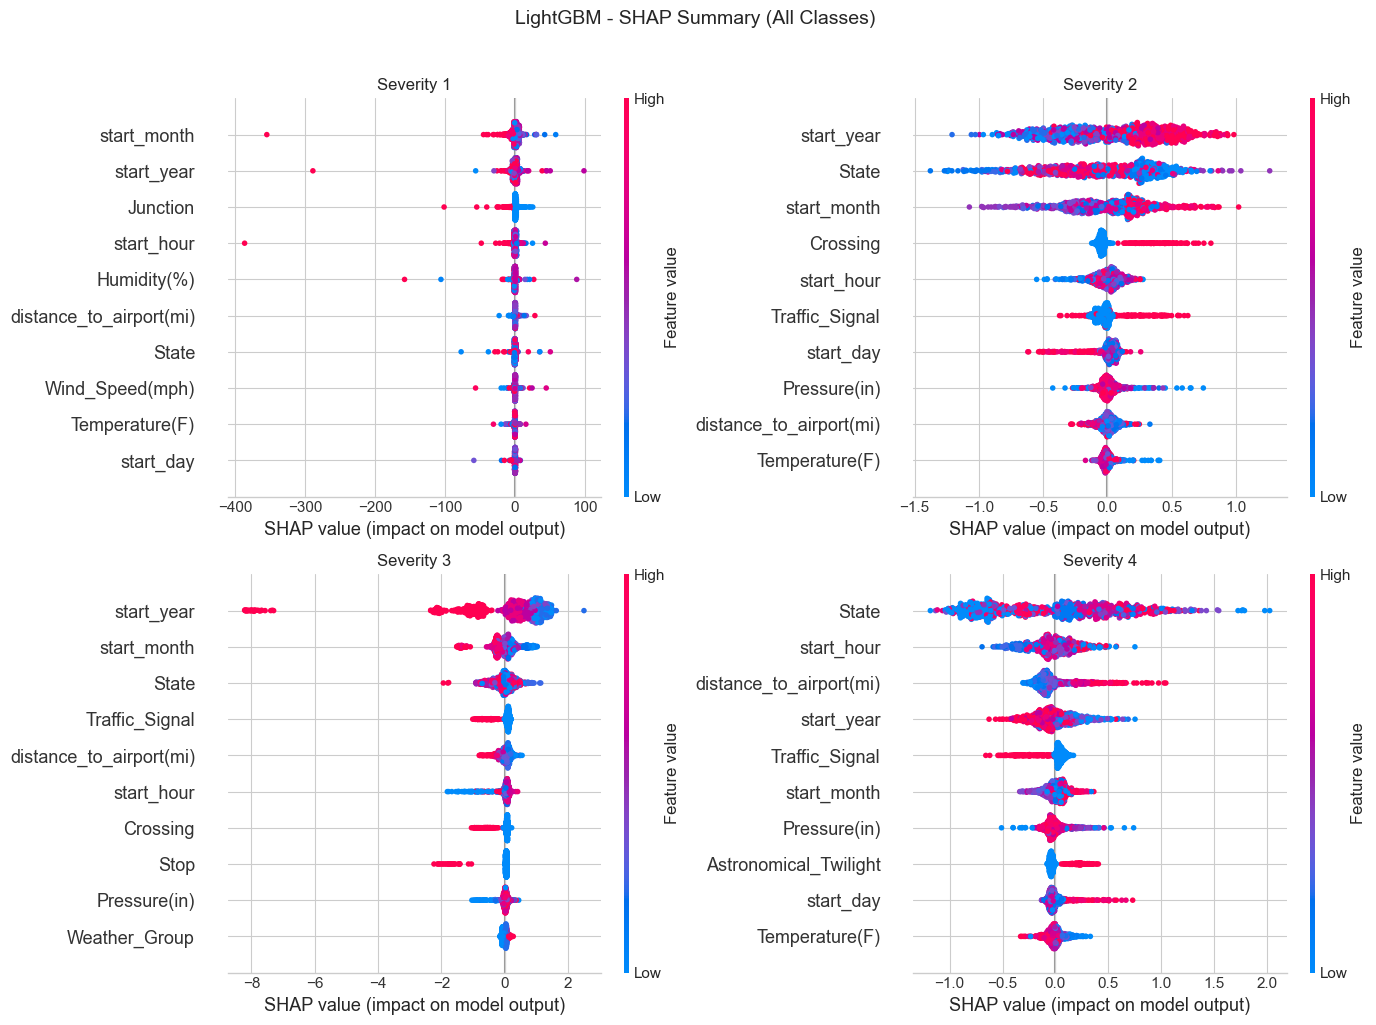


Generating detailed summary for high-severity classes...


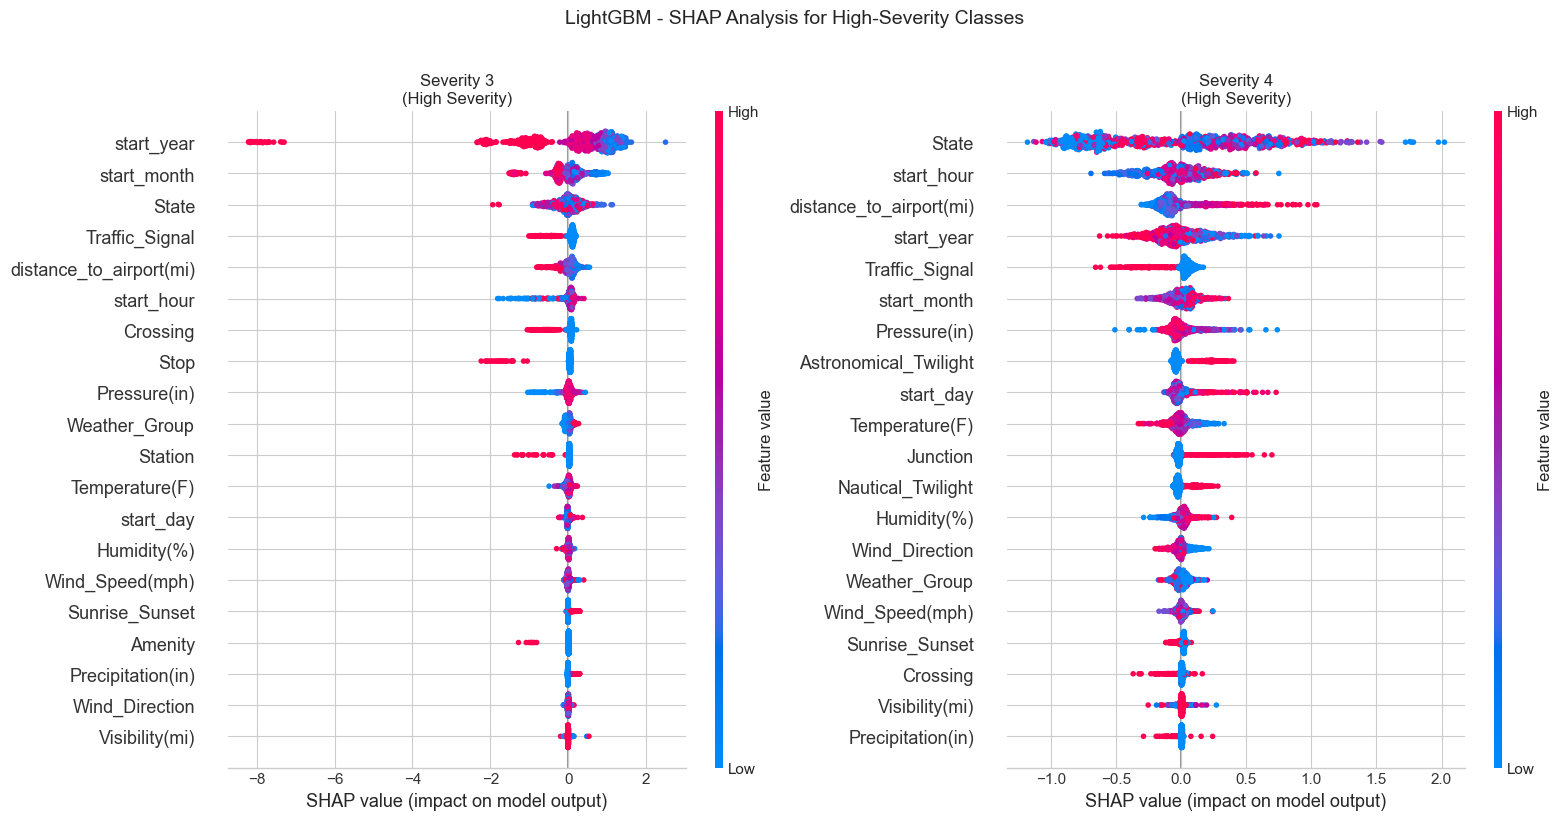


Generating feature importance comparison...


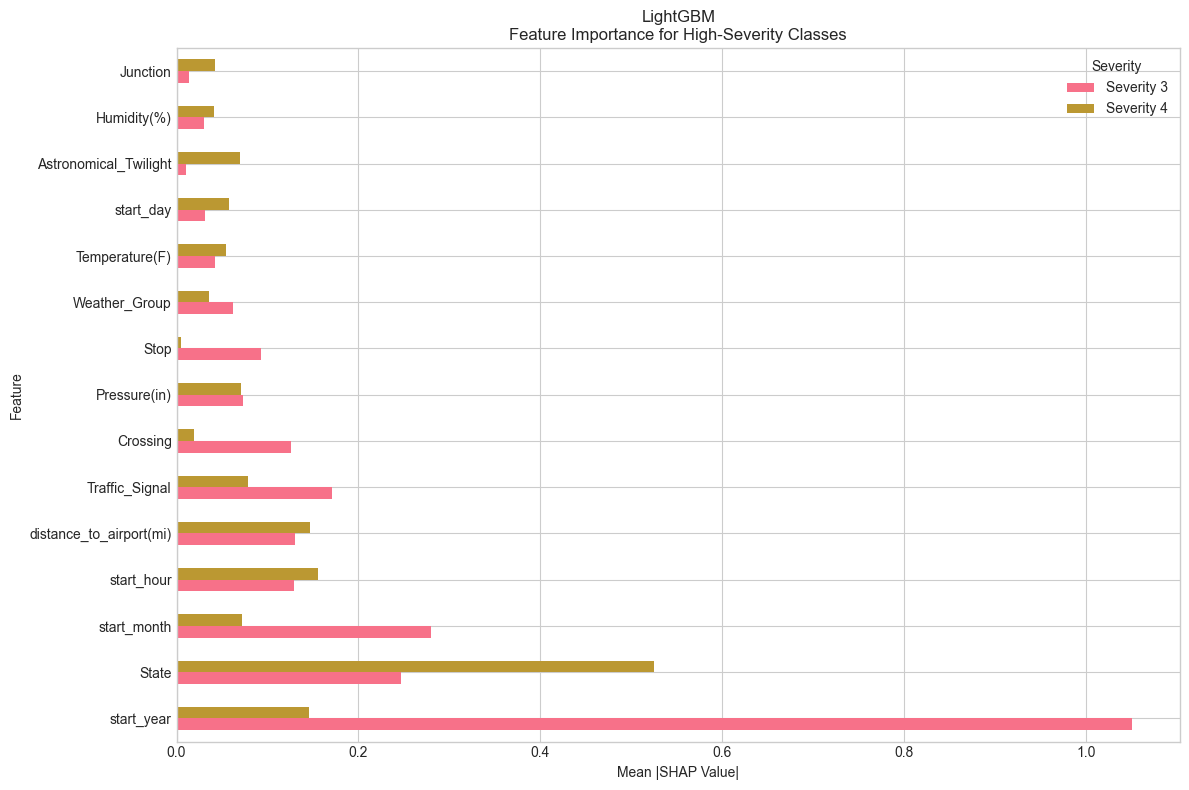


Generating dependence plots for high-severity classes...


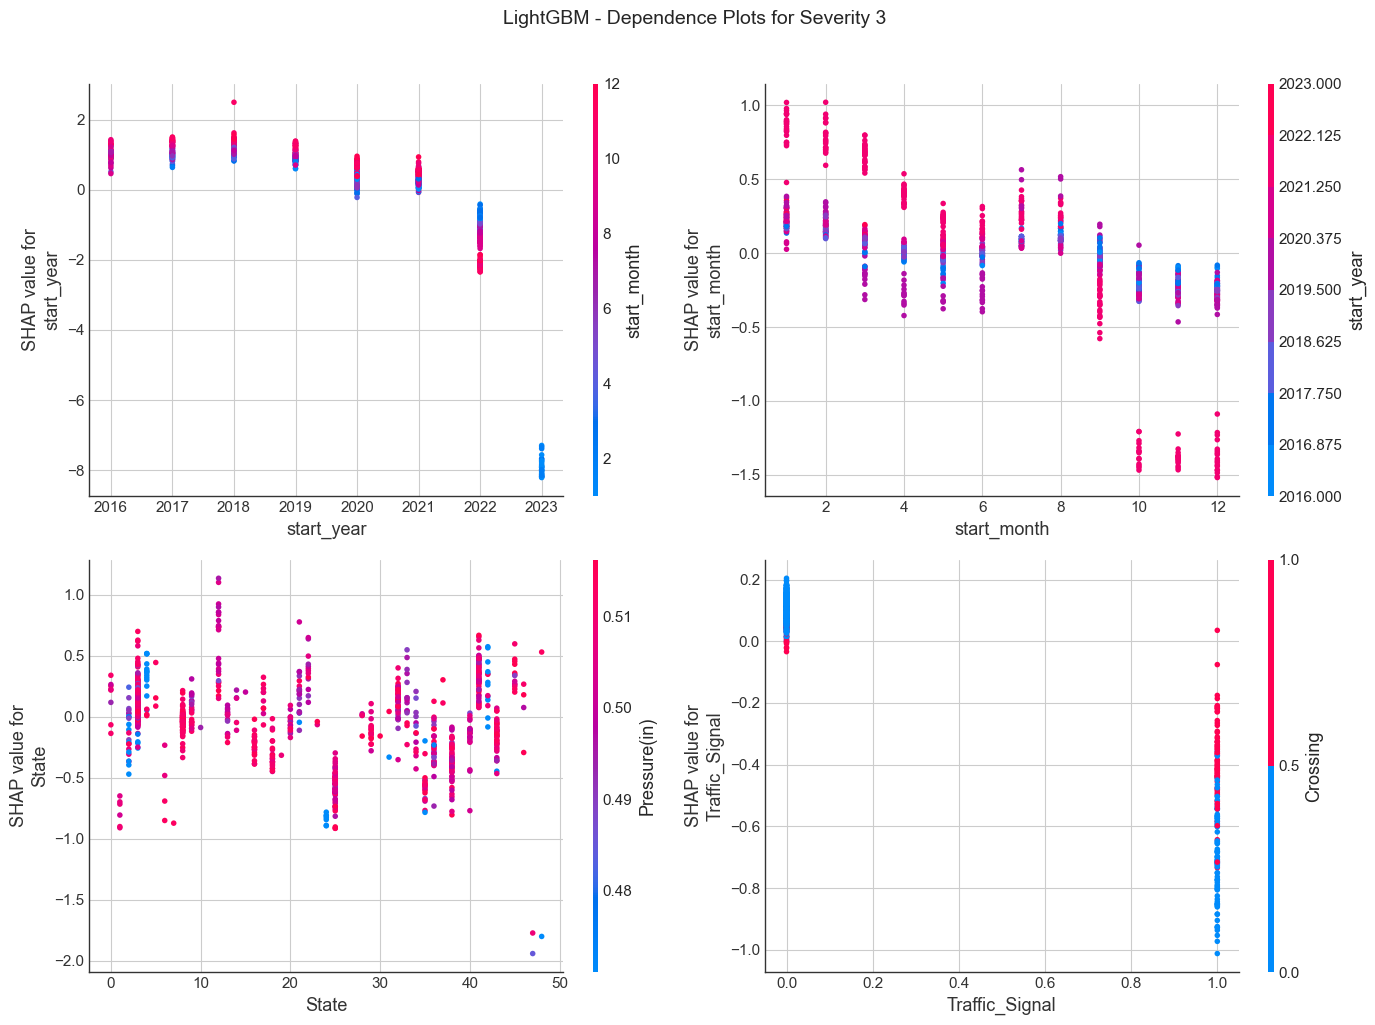

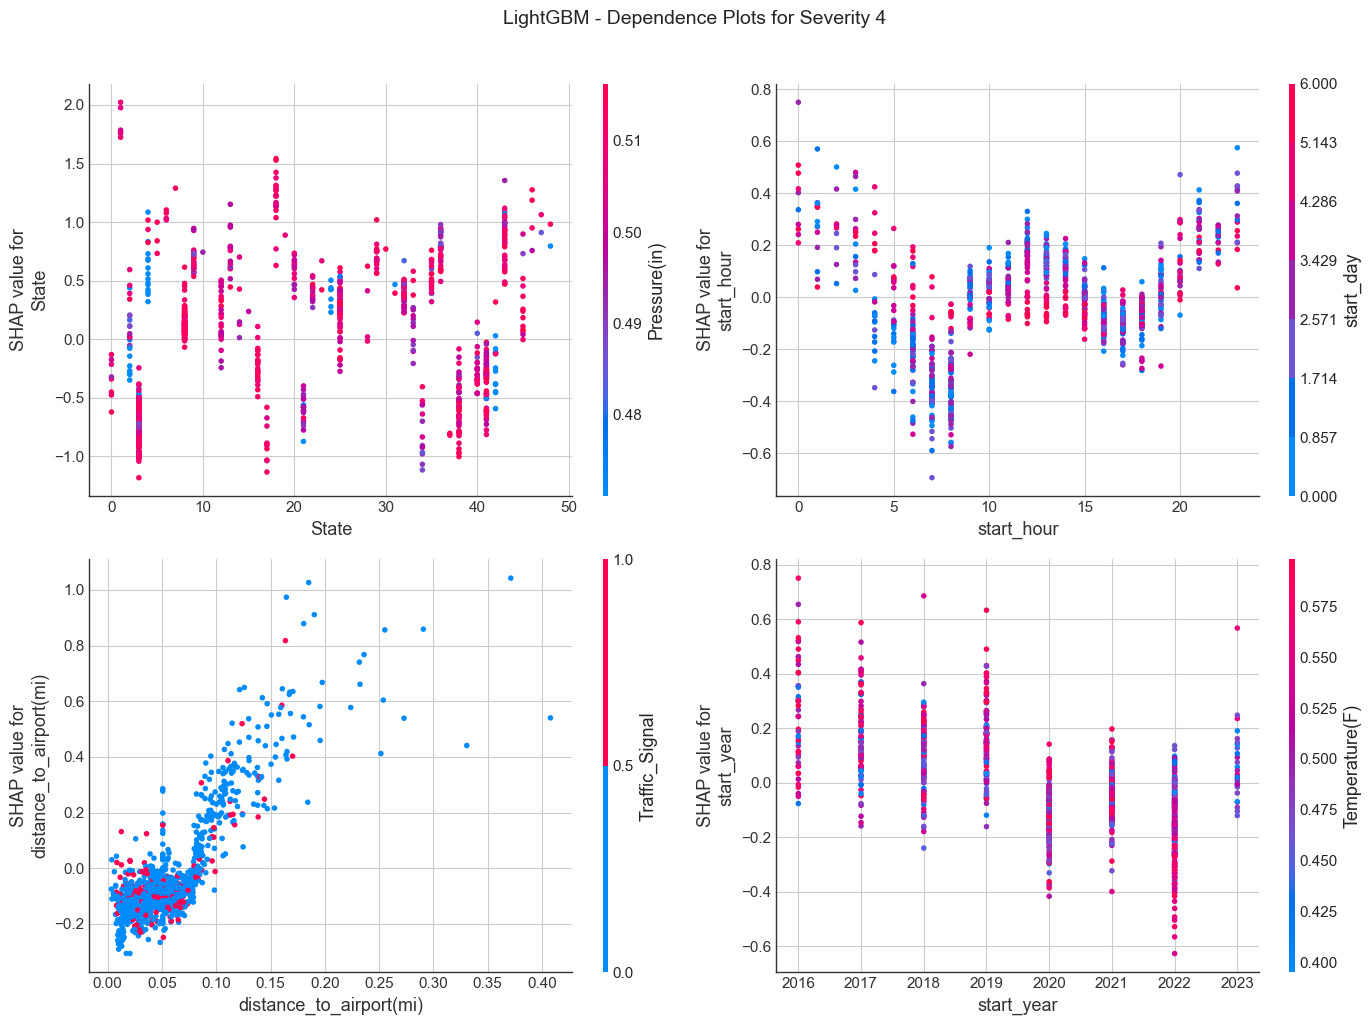


Generating decision plots for high-severity predictions...


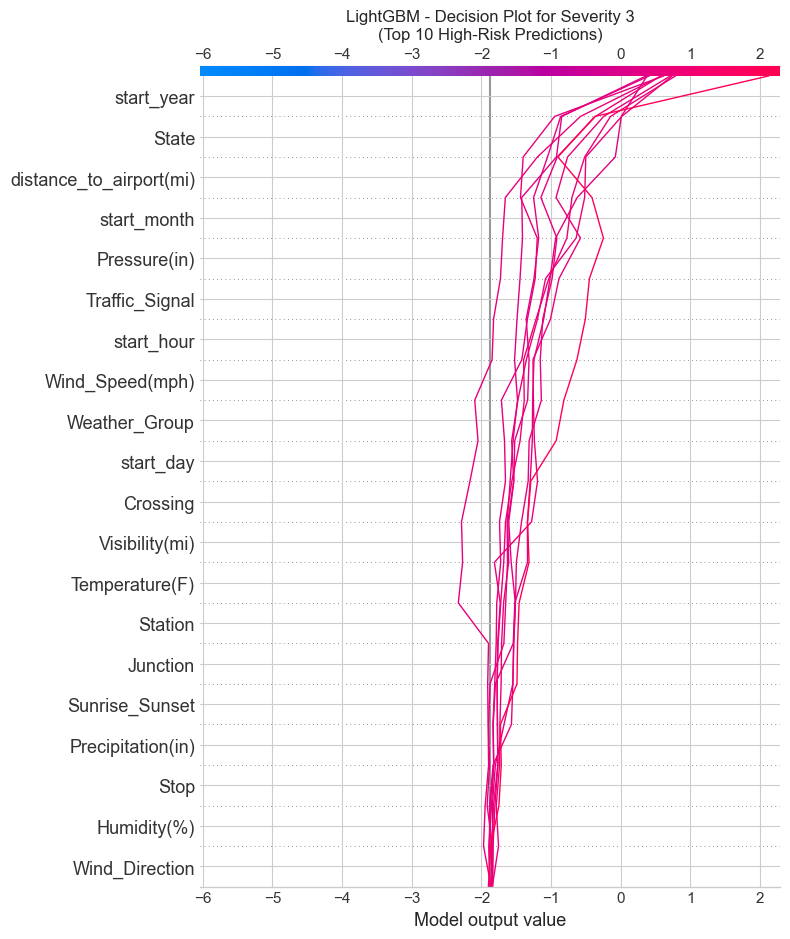

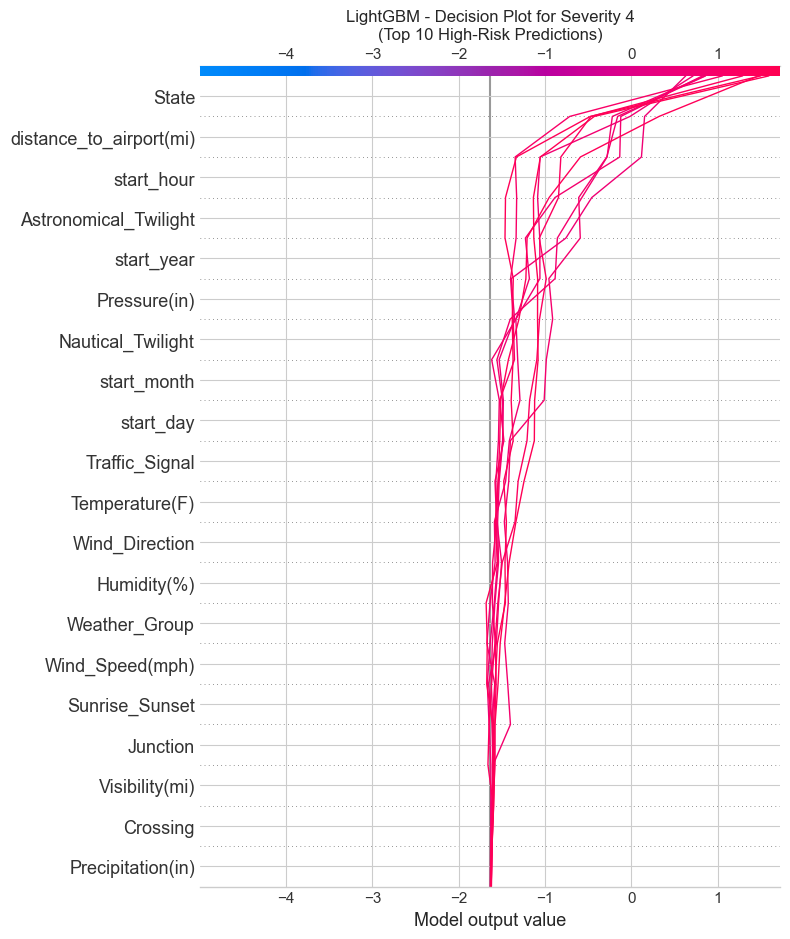


SHAP analysis complete!
   Severity Class                  Feature  Mean |SHAP|  Mean SHAP  \
0               3               start_year     1.050756   0.033407   
1               3              start_month     0.279489  -0.019617   
2               3                    State     0.246727  -0.029202   
3               3           Traffic_Signal     0.171455   0.000658   
4               3  distance_to_airport(mi)     0.130509   0.000438   
5               3               start_hour     0.128992  -0.015799   
6               3                 Crossing     0.125769  -0.005669   
7               3                     Stop     0.093125  -0.009613   
8               3             Pressure(in)     0.072664  -0.001118   
9               3            Weather_Group     0.061550  -0.001537   
10              3                  Station     0.044916   0.006639   
11              3           Temperature(F)     0.042319  -0.004148   
12              3                start_day     0.031365   0.00113

In [36]:
top_features = run_shap_for_model(
    best_model, 
    best_model_name,
    pipeline.X_train,
    pipeline.X_test,
    label_encoder,
    results['feature_names'],
    focus_classes=[2, 3]
)
print(top_features)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_comparison_radar(evaluation_results):
    """Create a radar chart comparing model performance."""
    
    from math import pi
    
    metrics = ['Balanced Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1', 'MCC']
    
    # Filter metrics that exist
    available_metrics = [m for m in metrics if m in list(evaluation_results.values())[0]]
    
    # Number of metrics
    N = len(available_metrics)
    
    # Angles for each metric
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    colors = plt.cm.Set2(np.linspace(0, 1, len(evaluation_results)))
    
    for (model_name, metrics_dict), color in zip(evaluation_results.items(), colors):
        values = [metrics_dict.get(m, 0) for m in available_metrics]
        values += values[:1]  # Close the loop
        
        ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color)
        ax.fill(angles, values, alpha=0.25, color=color)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(available_metrics, size=10)
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.title('Model Performance Comparison (Radar Chart)', size=14, y=1.1)
    
    plt.tight_layout()
    plt.savefig('../artifacts/model_insights/model_comparison_radar.png', dpi=150, bbox_inches='tight')
    plt.show()

# Example usage:
# plot_model_comparison_radar(pipeline.model_evaluator.evaluation_results)

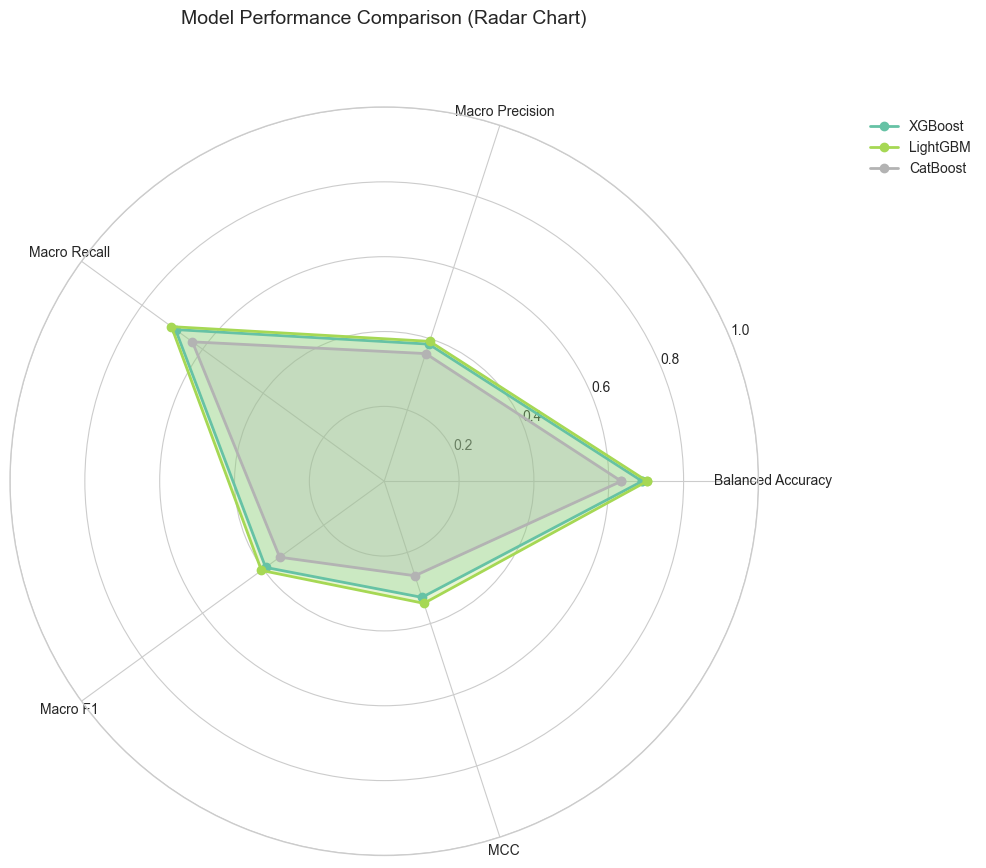

In [38]:
plot_model_comparison_radar(pipeline.model_evaluator.evaluation_results)

In [39]:
def plot_feature_importance_all_models(trained_models, feature_names, top_n=20):
    """Plot feature importance comparison across all models."""
    
    fig, axes = plt.subplots(1, len(trained_models), figsize=(7 * len(trained_models), 10))
    
    if len(trained_models) == 1:
        axes = [axes]
    
    for ax, (model_name, model) in zip(axes, trained_models.items()):
        classifier = model.named_steps['classifier']
        
        # Get feature importance
        if hasattr(classifier, 'feature_importances_'):
            importances = classifier.feature_importances_
        else:
            continue
        
        # Create DataFrame
        importance_df = pd.DataFrame({
            'Feature': feature_names[:len(importances)],
            'Importance': importances
        }).sort_values('Importance', ascending=True).tail(top_n)
        
        ax.barh(importance_df['Feature'], importance_df['Importance'])
        ax.set_xlabel('Importance')
        ax.set_title(f'{model_name}\nTop {top_n} Features')
    
    plt.tight_layout()
    plt.savefig('../artifacts/model_insights/feature_importance_all_models.png', dpi=150, bbox_inches='tight')
    plt.show()

# Example usage:
# plot_feature_importance_all_models(
#     results['trained_models'],
#     results['feature_names'],
#     top_n=20
# )

In [ ]:
def optimize_threshold_for_severity(model, X_test, y_test, target_class, label_encoder):
    """
    Optimize prediction threshold for high-severity class detection.
    
    This is useful when you want to maximize recall for dangerous accidents.
    """
    from sklearn.metrics import precision_recall_curve, f1_score
    
    y_proba = model.predict_proba(X_test)
    
    # Get probability for target class
    class_idx = list(label_encoder.classes_).index(target_class)
    proba_target = y_proba[:, class_idx]
    
    # Binary target
    y_binary = (y_test == class_idx).astype(int)
    
    # Calculate precision-recall at various thresholds
    precision, recall, thresholds = precision_recall_curve(y_binary, proba_target)
    
    # Calculate F1 for each threshold
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
    
    # Find best threshold
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    best_precision = precision[best_idx]
    best_recall = recall[best_idx]
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Precision-Recall vs Threshold
    axes[0].plot(thresholds, precision[:-1], 'b-', label='Precision')
    axes[0].plot(thresholds, recall[:-1], 'r-', label='Recall')
    axes[0].plot(thresholds, f1_scores, 'g-', label='F1')
    axes[0].axvline(x=best_threshold, color='k', linestyle='--', 
                    label=f'Best Threshold: {best_threshold:.3f}')
    axes[0].set_xlabel('Threshold')
    axes[0].set_ylabel('Score')
    axes[0].set_title(f'Threshold Optimization for Severity {target_class}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    axes[1].plot(recall, precision, 'b-', linewidth=2)
    axes[1].scatter([best_recall], [best_precision], color='red', s=100, 
                   label=f'Best F1: {best_f1:.3f}\nP={best_precision:.3f}, R={best_recall:.3f}')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title(f'Precision-Recall Curve for Severity {target_class}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'threshold_optimization_severity_{target_class}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n🎯 Optimal Threshold for Severity {target_class}:")
    print(f"   Threshold: {best_threshold:.4f}")
    print(f"   Precision: {best_precision:.4f}")
    print(f"   Recall: {best_recall:.4f}")
    print(f"   F1 Score: {best_f1:.4f}")
    
    return {
        'threshold': best_threshold,
        'precision': best_precision,
        'recall': best_recall,
        'f1': best_f1
    }

# Example usage for Severity 4:
# threshold_results = optimize_threshold_for_severity(
#     best_model,
#     pipeline.X_test,
#     pipeline.y_test_encoded,
#     target_class=4,  # Original severity label
#     label_encoder=label_encoder
# )